Dengue fever is bad. It's real bad. Dengue is a mosquito-borne disease that occurs in tropical and sub-tropical parts of the world. In mild cases, symptoms are similar to the flu: fever, rash and muscle and joint pain. But severe cases are dangerous, and dengue fever can cause severe bleeding, low blood pressure and even death.

Because it is carried by mosquitoes, the transmission dynamics of dengue are related to climate variables such as temperature and precipitation. Although the relationship to climate is complex, a growing number of scientists argue that climate change is likely to produce distributional shifts that will have significant public health implications worldwide.

We've [launched a competition](https://www.drivendata.org/competitions/44/) to use open data to predict the occurrence of Dengue based on climatological data. Here's a first look at the data and how to get started!

## Table of contents

* <a href='#intro'>Intro: A tale of two cities</a>  
* <a href='#first_look'>A first look in the data</a>  
* <a href='#Fixing_NaNs'>Fixing missing entries</a>  
* <a href='#reindex'>Re-indexing</a>
* <a href='#feature_engineering'>Feature engineering</a>
* <a href='#model'>Developing a predictive model</a>
* <a href='#negative_binomial'>Negative binomial regression</a>
* <a href='#process_data'>Pre-processing the data</a>
* <a href='#window_generator'>Window generator</a>
* Predictive models:
    * <a href='#linear'>Linear model</a>
    * <a href='#dense'>Dense model</a>
    * <a href='#LSTM'>LSTM</a>
* <a href='#many_steps_future'>Predicting many steps in the future</a>
* <a href='#autoregressive_LSTM'>Autoregressive LSTM</a>
* <a href='#test_implementation'>Implement on test set</a>
* <a href='#explicit_autoregressive_LSTM'>Explicitly trained autoregressive LSTM</a>


In [188]:
from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split
import statsmodels.api as sm


<a id='intro'></a>

## A Tale of Two Cities

![](https://community.drivendata.org/uploads/default/original/1X/4c3a8204d1715b5e2ee24da78abbad1515eccd5f.png)

This dataset has two cities in it: San Juan, Puerto Rico (right) and Iquitos, Peru (left). Since we hypothesize that the spread of dengue may follow different patterns between the two, we will divide the dataset, train seperate models for each city, and then join our predictions before making our final submission.

In [207]:
# load the provided data
train_features = pd.read_csv('data/Training_data_features.csv',
                             index_col=[0,1,2])

train_labels = pd.read_csv('data/Training_data_labels.csv',
                           index_col=[0,1,2])

In [208]:
# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

In [4]:
print('San Juan')
print('features: ', sj_train_features.shape)
print('labels  : ', sj_train_labels.shape)

print('\nIquitos')
print('features: ', iq_train_features.shape)
print('labels  : ', iq_train_labels.shape)

San Juan
features:  (936, 21)
labels  :  (936, 1)

Iquitos
features:  (520, 21)
labels  :  (520, 1)


The [problem description](https://www.drivendata.org/competitions/44/page/82/) gives a good overview of the available variables, but we'll look at the head of the data here as well:

In [5]:
iq_train_features.head()

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear                                                           
2000 26              2000-07-01  0.192886  0.132257  0.340886  0.247200   
     27              2000-07-08  0.216833  0.276100  0.289457  0.241657   
     28              2000-07-15  0.176757  0.173129  0.204114  0.128014   
     29              2000-07-22  0.227729  0.145429  0.254200  0.200314   
     30              2000-07-29  0.328643  0.322129  0.254371  0.361043   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear                                                
2000 26                         25.41             296.740000   
     27                         60.61             296.634286   
     28                         55.52             296.415714   
     29                          5.60             295.357143   
     30                         62.76             296.432857   

                 reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
year weekofyear                                                       
2000 26                     298.450000                   295.184286   
     27                     298.428571                   295.358571   
     28                     297.392857                   295.622857   
     29                     296.228571                   292.797143   
     30                     297.635714                   293.957143   

                 reanalysis_max_air_temp_k  ...  \
year weekofyear                             ...   
2000 26                              307.3  ...   
     27                              306.6  ...   
     28                              304.5  ...   
     29                              303.6  ...   
     30                              307.0  ...   

                 reanalysis_precip_amt_kg_per_m2  \
year weekofyear                                    
2000 26                                    43.19   
     27                                    46.00   
     28                                    64.77   
     29                                    23.96   
     30                                    31.80   

                 reanalysis_relative_humidity_percent  \
year weekofyear                                         
2000 26                                     92.418571   
     27                                     93.581429   
     28                                     95.848571   
     29                                     87.234286   
     30                                     88.161429   

                 reanalysis_sat_precip_amt_mm  \
year weekofyear                                 
2000 26                                 25.41   
     27                                 60.61   
     28                                 55.52   
     29                                  5.60   
     30                                 62.76   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
year weekofyear                                                             
2000 26                                      16.651429           8.928571   
     27                                      16.862857          10.314286   
     28                                      17.120000           7.385714   
     29                                      14.431429           9.114286   
     30                                      15.444286           9.500000   

                 station_avg_temp_c  station_diur_temp_rng_c  \
year weekofyear                                                
2000 26                   26.400000                10.775000   
     27                   26.900000                11.566667   
     28                   26.800000                11.466667   
     29                   25.766667                10.533333   
     30                   26.600000                11.480000   

                 station_max_temp_c  station_min_temp_c  station_precip_mm  
year weeko

In [7]:
## with pandas_profiling
import pandas_profiling
from pandas_profiling import ProfileReport
profile = ProfileReport(iq_train_features, explorative=True, dark_mode=True)
profile.to_file('dengue.html')


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
## with dtale
import dtale 
dtale.show(iq_train_features)

Next, let's check to see if we are missing any values in this dataset:

In [8]:
# Null check
pd.isnull(sj_train_features).any()

week_start_date                          False
ndvi_ne                                   True
ndvi_nw                                   True
ndvi_se                                   True
ndvi_sw                                   True
precipitation_amt_mm                      True
reanalysis_air_temp_k                     True
reanalysis_avg_temp_k                     True
reanalysis_dew_point_temp_k               True
reanalysis_max_air_temp_k                 True
reanalysis_min_air_temp_k                 True
reanalysis_precip_amt_kg_per_m2           True
reanalysis_relative_humidity_percent      True
reanalysis_sat_precip_amt_mm              True
reanalysis_specific_humidity_g_per_kg     True
reanalysis_tdtr_k                         True
station_avg_temp_c                        True
station_diur_temp_rng_c                   True
station_max_temp_c                        True
station_min_temp_c                        True
station_precip_mm                         True
dtype: bool

Since these are time-series, we can see the gaps where there are `NaN`s by plotting the data. Since we can't build a model without those values, we'll take a simple approach and just fill those values with the most recent value that we saw up to that point. This is probably a good part of the problem to improve your score by getting smarter.

Text(0.5, 0, 'Time')

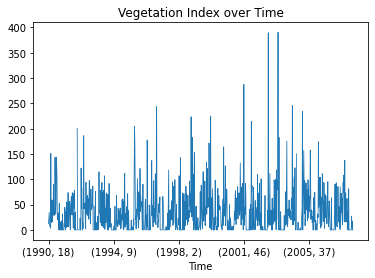

In [14]:
(sj_train_features
     .precipitation_amt_mm
     .plot
     .line(lw=0.8))

plt.title('Vegetation Index over Time')
plt.xlabel('Time')

<a id='first_look'></a>

## A first look in the data

In [11]:
sj_train_features.corrwith(sj_train_features.ndvi_ne)

ndvi_ne                                  1.000000
ndvi_nw                                  0.673037
ndvi_se                                  0.234049
ndvi_sw                                  0.177792
precipitation_amt_mm                    -0.048727
reanalysis_air_temp_k                   -0.073170
reanalysis_avg_temp_k                   -0.071176
reanalysis_dew_point_temp_k             -0.040008
reanalysis_max_air_temp_k               -0.044553
reanalysis_min_air_temp_k               -0.096176
reanalysis_precip_amt_kg_per_m2          0.004448
reanalysis_relative_humidity_percent     0.039138
reanalysis_sat_precip_amt_mm            -0.048727
reanalysis_specific_humidity_g_per_kg   -0.035235
reanalysis_tdtr_k                       -0.009248
station_avg_temp_c                       0.064027
station_diur_temp_rng_c                  0.142875
station_max_temp_c                       0.092365
station_min_temp_c                       0.018818
station_precip_mm                       -0.085993


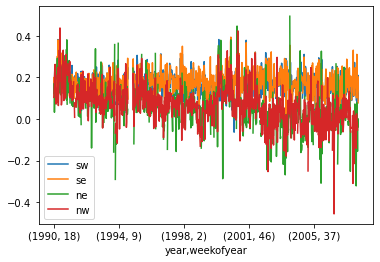

In [15]:
ax=sj_train_features['ndvi_sw'].plot()
sj_train_features['ndvi_se'].plot(ax=ax)
sj_train_features['ndvi_ne'].plot(ax=ax)
sj_train_features['ndvi_nw'].plot(ax=ax)
ax.legend(['sw','se','ne','nw'])

### Note:
The above NDVI are measures of the Satellite vegetation - Normalized difference vegetation index (NDVI) at the 4 pixels around the city centroid.
These should perhaps be combined to show something useful. Maybe the average makes the most sense. Or simply drop ~2 of these, since they seem to be highly correlated in pairs. We can also use this feature to fill missing values.

<AxesSubplot:xlabel='year,weekofyear'>

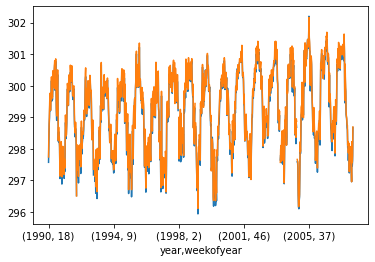

In [16]:
ax=sj_train_features['reanalysis_air_temp_k'].plot()
sj_train_features['reanalysis_avg_temp_k'].plot(ax=ax)

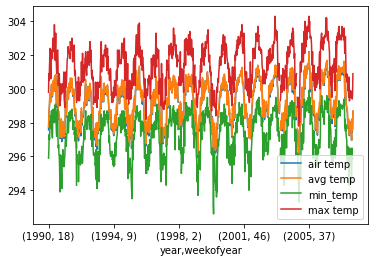

In [17]:
ax=sj_train_features['reanalysis_air_temp_k'].plot(label='air temp')
sj_train_features['reanalysis_avg_temp_k'].plot(ax=ax, label='avg temp')
sj_train_features['reanalysis_min_air_temp_k'].plot(ax=ax, label='min_temp')
sj_train_features['reanalysis_max_air_temp_k'].plot(ax=ax, label='max temp')
ax.legend()

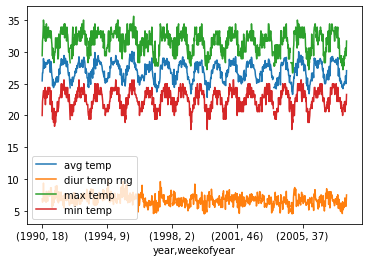

In [18]:
ax=sj_train_features['station_avg_temp_c'].plot(label='avg temp')
sj_train_features['station_diur_temp_rng_c'].plot(ax=ax,label='diur temp rng')
sj_train_features['station_max_temp_c'].plot(ax=ax,label='max temp')
sj_train_features['station_min_temp_c'].plot(ax=ax,label='min temp')
ax.legend()

### Note
Many of the temp variables are highly correlated, and largely repeat the same information.

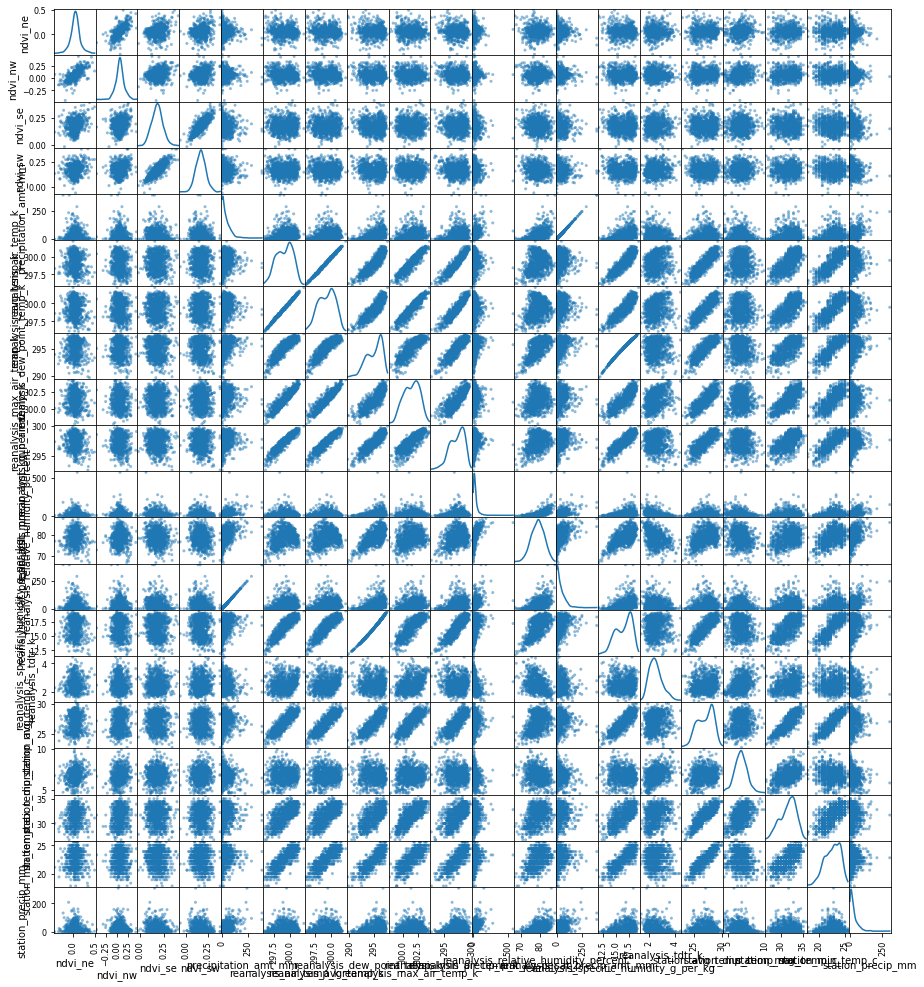

In [19]:
from pandas.plotting import scatter_matrix
scatter_matrix(sj_train_features, alpha=0.5, figsize=(15, 17), diagonal='kde');

<a id='Fixing_NaNs'></a>

## Fixing NaN's


Let's examine the NaN values in our dataset.

In [209]:
np.isnan(sj_train_features['ndvi_ne']).sum()

191

In [210]:
sj_train_features.week_start_date.loc[ np.isnan(sj_train_features.ndvi_sw) ]

year  weekofyear
1993  53            1993-01-01
1994  52            1994-01-01
      38            1994-09-24
      39            1994-10-01
      40            1994-10-08
      41            1994-10-15
      42            1994-10-22
      43            1994-10-29
      44            1994-11-05
      45            1994-11-12
      46            1994-11-19
      47            1994-11-26
      48            1994-12-03
      49            1994-12-10
      50            1994-12-17
      51            1994-12-24
1999  53            1999-01-01
2002  5             2002-01-29
2005  53            2005-01-01
Name: week_start_date, dtype: object

In [211]:
sj_train_features.columns.tolist()

['week_start_date',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm']

In [212]:
for column in sj_train_features.columns.tolist():
    if column == 'week_start_date': continue
    n_nans=np.isnan(sj_train_features[column]).sum()
    if n_nans>0:
        print (column, n_nans)

ndvi_ne 191
ndvi_nw 49
ndvi_se 19
ndvi_sw 19
precipitation_amt_mm 9
reanalysis_air_temp_k 6
reanalysis_avg_temp_k 6
reanalysis_dew_point_temp_k 6
reanalysis_max_air_temp_k 6
reanalysis_min_air_temp_k 6
reanalysis_precip_amt_kg_per_m2 6
reanalysis_relative_humidity_percent 6
reanalysis_sat_precip_amt_mm 9
reanalysis_specific_humidity_g_per_kg 6
reanalysis_tdtr_k 6
station_avg_temp_c 6
station_diur_temp_rng_c 6
station_max_temp_c 6
station_min_temp_c 6
station_precip_mm 6


Let's start replacing missing values, using other correlated variables.  Let's start with the highly correlated ndvi's:

In [213]:
sj_train_features.ndvi_nw.fillna(sj_train_features.ndvi_ne, inplace=True)
sj_train_features.ndvi_ne.fillna(sj_train_features.ndvi_nw, inplace=True)
sj_train_features.ndvi_sw.fillna(sj_train_features.ndvi_se, inplace=True)
sj_train_features.ndvi_se.fillna(sj_train_features.ndvi_sw, inplace=True)

/opt/anaconda3/envs/track_ML/lib/python3.7/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [214]:
sj_train_features.ndvi_nw.fillna(0.5*(sj_train_features.ndvi_sw+sj_train_features.ndvi_se), inplace=True)
sj_train_features.ndvi_ne.fillna(0.5*(sj_train_features.ndvi_sw+sj_train_features.ndvi_se), inplace=True)
sj_train_features.ndvi_sw.fillna(0.5*(sj_train_features.ndvi_nw+sj_train_features.ndvi_ne), inplace=True)
sj_train_features.ndvi_se.fillna(0.5*(sj_train_features.ndvi_nw+sj_train_features.ndvi_ne), inplace=True)

In [215]:
## was 191, now way less
np.isnan(sj_train_features['ndvi_ne']).sum()

19

In [216]:
sj_train_features.ndvi_ne.loc[np.isnan(sj_train_features['ndvi_ne'])]

year  weekofyear
1993  53           NaN
1994  52           NaN
      38           NaN
      39           NaN
      40           NaN
      41           NaN
      42           NaN
      43           NaN
      44           NaN
      45           NaN
      46           NaN
      47           NaN
      48           NaN
      49           NaN
      50           NaN
      51           NaN
1999  53           NaN
2002  5            NaN
2005  53           NaN
Name: ndvi_ne, dtype: float64

So only one period in 1994 has contiguous NaNs, otherwise it's mostly that weird week at the change of year, plus just 1 more missing value in 2002.

Get rows around each of these specific rows:

In [217]:
sj_train_features.index[np.isnan(sj_train_features['ndvi_ne'])]

MultiIndex([(1993, 53),
            (1994, 52),
            (1994, 38),
            (1994, 39),
            (1994, 40),
            (1994, 41),
            (1994, 42),
            (1994, 43),
            (1994, 44),
            (1994, 45),
            (1994, 46),
            (1994, 47),
            (1994, 48),
            (1994, 49),
            (1994, 50),
            (1994, 51),
            (1999, 53),
            (2002,  5),
            (2005, 53)],
           names=['year', 'weekofyear'])

In [218]:
## Lets look at all values in 1994
sj_train_features.loc[sj_train_features.index.get_level_values('year')==1994]

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear                                                           
1994 52              1994-01-01       NaN       NaN       NaN       NaN   
     1               1994-01-08 -0.120900  0.019300  0.094986  0.178514   
     2               1994-01-15  0.143500  0.097400  0.254250  0.214450   
     3               1994-01-22  0.074100  0.166433  0.151000  0.140714   
     4               1994-01-29  0.091200 -0.116267  0.163557  0.198514   
     5               1994-02-05  0.258800  0.211200  0.220057  0.215600   
     6               1994-02-12  0.088200  0.117000  0.076800  0.069175   
     7               1994-02-19  0.363300  0.241850  0.247386  0.283414   
     8               1994-02-26  0.092433  0.092433  0.137757  0.074071   
     9               1994-03-05  0.144600  0.144600  0.174150  0.153083   
     10              1994-03-12  0.112500  0.103800  0.088214  0.122414   
     11              1994-03-19  0.146800 -0.048150  0.194683  0.140550   
     12              1994-03-26  0.041200  0.100583  0.152817  0.136843   
     13              1994-04-02  0.097800  0.159750  0.127043  0.119529   
     14              1994-04-09  0.108000  0.050933  0.136929  0.119029   
     15              1994-04-16  0.164350  0.133250  0.187429  0.155243   
     16              1994-04-23  0.164143  0.164143  0.152829  0.175457   
     17              1994-04-30  0.080500  0.025100  0.098043  0.093717   
     18              1994-05-07  0.065200  0.081750  0.164414  0.132143   
     19              1994-05-14  0.111100  0.097400  0.116514  0.106314   
     20              1994-05-21  0.074200  0.017700  0.172243  0.160829   
     21              1994-05-28  0.117800  0.109750  0.208471  0.208486   
     22              1994-06-04  0.109700  0.140700  0.200843  0.161614   
     23              1994-06-11  0.080050  0.069050  0.061614  0.058543   
     24              1994-06-18 -0.028600 -0.028600  0.159283  0.215843   
     25              1994-06-25 -0.032300  0.042150  0.138743  0.139114   
     26              1994-07-02  0.125267  0.117650  0.123417  0.155186   
     27              1994-07-09  0.123250  0.215567  0.217000  0.113343   
     28              1994-07-16  0.139600  0.224050  0.184671  0.180586   
     29              1994-07-23  0.042400  0.120167  0.194343  0.190743   
     30              1994-07-30  0.183000  0.265800  0.196729  0.193900   
     31              1994-08-06  0.131100  0.131100  0.175214  0.112214   
     32              1994-08-13  0.044650 -0.040200  0.056867  0.028650   
     33              1994-08-20  0.066667 -0.015700  0.176617  0.221350   
     34              1994-08-27  0.156400  0.130825  0.192057  0.176729   
     35              1994-09-03  0.021850  0.145250  0.213786  0.204086   
     36              1994-09-10  0.045850  0.076225  0.291686  0.247971   
     37              1994-09-17  0.144213  0.144213  0.095500  0.192925   
     38              1994-09-24       NaN       NaN       NaN       NaN   
     39              1994-10-01       NaN       NaN       NaN       NaN   
     40              1994-10-08       NaN       NaN       NaN       NaN   
     41              1994-10-15       NaN       NaN       NaN       NaN   
     42              1994-10-22       NaN       NaN       NaN       NaN   
     43              1994-10-29       NaN       NaN       NaN       NaN   
     44              1994-11-05       NaN       NaN       NaN       NaN   
     45              1994-11-12       NaN       NaN       NaN       NaN   
     46              1994-11-19       NaN       NaN       NaN       NaN   
     47              1994-11-26       NaN       NaN       NaN       NaN   
     48              1994-12-03       NaN       NaN       NaN       NaN   
     49              1994-12-10       NaN       NaN       NaN       NaN   
     50              1994-12-17       NaN       NaN       NaN       NaN   
     51              1994-12-24       NaN

<AxesSubplot:ylabel='Frequency'>

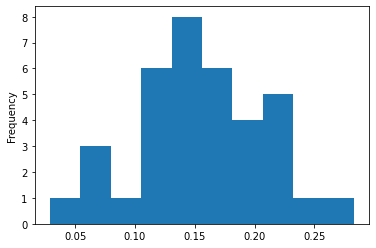

In [219]:
## Maybe the average over the entire dataset in too meaningless to fill the NaNs
## but how about just the average of the year 1994 before the missing period?
sj_train_features.ndvi_sw.loc[( sj_train_features.index.get_level_values('weekofyear')<37 ) & ( sj_train_features.index.get_level_values('year')==1994 )].plot.hist()

<AxesSubplot:ylabel='Frequency'>

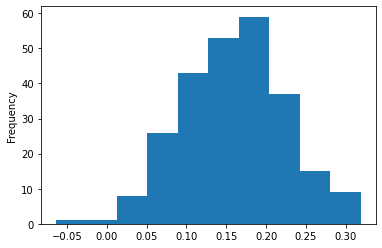

In [220]:
## Or perhaps we can expect some seasonality in NDVI, when it would make more sense to get the average for that time of year over all years
sj_train_features.ndvi_sw.loc[sj_train_features.index.get_level_values('weekofyear')>37].plot.hist()

Lets fill the NDVI NaNs with their average value from the above two histograms:

In [221]:
sj_train_features.ndvi_ne = sj_train_features.ndvi_ne.fillna(0.08)
sj_train_features.ndvi_nw = sj_train_features.ndvi_nw.fillna(0.1)
sj_train_features.ndvi_se = sj_train_features.ndvi_se.fillna(0.17)
sj_train_features.ndvi_sw = sj_train_features.ndvi_sw.fillna(0.16)

/opt/anaconda3/envs/track_ML/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [222]:
np.isnan(sj_train_features['ndvi_ne']).sum()

0

Next for other columns. Looks like we have some entries with all NaN's:

In [223]:
sj_train_features.loc[np.isnan(sj_train_features['reanalysis_air_temp_k'])]

,,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
year,weekofyear,,,,,,,,,,,,,,,,,,,,,
1992,1,1992-01-01,0.1251,0.157867,0.185283,0.181367,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993,53,1993-01-01,0.0800,0.100000,0.170000,0.160000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,1,1998-01-01,0.0455,0.047800,0.123986,0.083443,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999,53,1999-01-01,0.0800,0.100000,0.170000,0.160000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004,1,2004-01-01,-0.2683,-0.123700,0.223757,0.176543,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005,53,2005-01-01,0.0800,0.100000,0.170000,0.160000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's drop these specific entries:

In [224]:
sj_train_features = sj_train_features.dropna(subset=['reanalysis_air_temp_k'])

In [225]:
sj_train_features.loc[np.isnan(sj_train_features['reanalysis_air_temp_k'])]

,,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
year,weekofyear,,,,,,,,,,,,,,,,,,,,,


Remaining NaNs:


In [226]:
for column in sj_train_features.columns.tolist():
    if column == 'week_start_date': continue
    n_nans=np.isnan(sj_train_features[column]).sum()
    if n_nans>0:
        print (column, n_nans)

precipitation_amt_mm 3
reanalysis_sat_precip_amt_mm 3


In [227]:
sj_train_features.loc[np.isnan(sj_train_features['precipitation_amt_mm'])]

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear                                                           
1992 7               1992-02-12  0.130500  0.130500  0.195743  0.178857   
     8               1992-02-19  0.184467  0.184467  0.194614  0.203057   
     9               1992-02-26  0.107050  0.081500  0.165243  0.163057   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear                                                
1992 7                            NaN             297.798571   
     8                            NaN             297.898571   
     9                            NaN             297.472857   

                 reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
year weekofyear                                                       
1992 7                      298.057143                   294.650000   
     8                      298.107143                   293.628571   
     9                      297.678571                   292.967143   

                 reanalysis_max_air_temp_k  ...  \
year weekofyear                             ...   
1992 7                               300.2  ...   
     8                               300.1  ...   
     9                               299.3  ...   

                 reanalysis_precip_amt_kg_per_m2  \
year weekofyear                                    
1992 7                                      20.1   
     8                                       4.4   
     9                                      14.4   

                 reanalysis_relative_humidity_percent  \
year weekofyear                                         
1992 7                                      82.875714   
     8                                      77.295714   
     9                                      76.037143   

                 reanalysis_sat_precip_amt_mm  \
year weekofyear                                 
1992 7                                    NaN   
     8                                    NaN   
     9                                    NaN   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
year weekofyear                                                             
1992 7                                       16.060000           2.200000   
     8                                       15.012857           2.585714   
     9                                       14.381429           2.414286   

                 station_avg_temp_c  station_diur_temp_rng_c  \
year weekofyear                                                
1992 7                    26.028571                 6.571429   
     8                    25.757143                 7.385714   
     9                    25.285714                 6.171429   

                 station_max_temp_c  station_min_temp_c  station_precip_mm  
year weekofyear                                                             
1992 7                         32.2                20.0                1.3  
     8                         33.9                21.7                8.9  
     9                         29.4                21.7               16.0  

[3 rows x 21 columns]

Lets look at the beginning of year 1992:

In [228]:
sj_train_features.loc[sj_train_features.index.get_level_values('year')==1992]

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear                                                           
1992 2               1992-01-08  0.100833  0.073575  0.138714  0.112786   
     3               1992-01-15  0.222400  0.229900  0.198457  0.199414   
     4               1992-01-22  0.122533  0.131050  0.188843  0.168871   
     5               1992-01-29  0.048300  0.048300  0.173671  0.191929   
     6               1992-02-05  0.101600  0.084600  0.111717  0.187957   
     7               1992-02-12  0.130500  0.130500  0.195743  0.178857   
     8               1992-02-19  0.184467  0.184467  0.194614  0.203057   
     9               1992-02-26  0.107050  0.081500  0.165243  0.163057   
     10              1992-03-04  0.182180  0.182180  0.191086  0.192857   
     11              1992-03-11  0.086850  0.090150  0.128000  0.155100   
     12              1992-03-18  0.053050  0.084050  0.141771  0.134514   
     13              1992-03-25  0.120821  0.120821  0.134843  0.106800   
     14              1992-04-01  0.099950  0.077650  0.193067  0.176900   
     15              1992-04-08  0.103900  0.131500  0.122471  0.124386   
     16              1992-04-15  0.075150  0.097433  0.159029  0.172986   
     17              1992-04-22  0.092200  0.113700  0.151414  0.154829   
     18              1992-04-29  0.012500  0.063500  0.070314  0.089443   
     19              1992-05-06  0.108750  0.216900  0.182329  0.207357   
     20              1992-05-13  0.101875 -0.008800  0.142067  0.125900   
     21              1992-05-20  0.102400  0.068600  0.062383  0.057400   
     22              1992-05-27  0.121500  0.121500  0.219157  0.213014   
     23              1992-06-03  0.121650  0.139950  0.110086  0.102229   
     24              1992-06-10  0.083950  0.085600  0.102371  0.111771   
     25              1992-06-17  0.104450  0.153150  0.181157  0.192086   
     26              1992-06-24  0.130200  0.130200  0.139380  0.114750   
     27              1992-07-01  0.119400  0.143900  0.169329  0.168471   
     28              1992-07-08  0.192000  0.192000  0.146857  0.153071   
     29              1992-07-15  0.112000  0.125500  0.142140  0.182533   
     30              1992-07-22 -0.139600  0.059180  0.137129  0.128871   
     31              1992-07-29  0.053900  0.126133  0.133771  0.149914   
     32              1992-08-05  0.152675  0.173275  0.150043  0.145057   
     33              1992-08-12  0.163950  0.126650  0.215057  0.219271   
     34              1992-08-19  0.114600  0.136800  0.185586  0.192571   
     35              1992-08-26  0.087500  0.081700  0.179943  0.221757   
     36              1992-09-02  0.217500  0.217500  0.124014  0.125657   
     37              1992-09-09  0.123975  0.176800  0.235743  0.214829   
     38              1992-09-16  0.051900  0.072267  0.177571  0.158814   
     39              1992-09-23  0.143500  0.143500  0.198400  0.212271   
     40              1992-09-30  0.197200  0.127150  0.158133  0.094350   
     41              1992-10-07  0.137225  0.107450  0.177186  0.191100   
     42              1992-10-14  0.337100  0.197900  0.194586  0.183229   
     43              1992-10-21 -0.015600  0.031200  0.104217  0.112983   
     44              1992-10-28  0.124200  0.125400  0.115600  0.112429   
     45              1992-11-04  0.086600  0.120967  0.224443  0.249857   
     46              1992-11-11  0.118000  0.142200  0.089450  0.066800   
     47              1992-11-18  0.076400  0.056133  0.134371  0.064014   
     48              1992-11-25  0.097100  0.102633  0.161714  0.119829   
     49              1992-12-02  0.108300  0.074125  0.175067  0.152750   
     50              1992-12-09  0.054700  0.109900  0.198157  0.215967   
     51              1992-12-16  0.066425  0.066425  0.192343  0.194129   
     52              1992-12-23 -0.010080  0.068217  0.086900  0.073313   

                 precipitation_amt_mm  r

<AxesSubplot:ylabel='Frequency'>

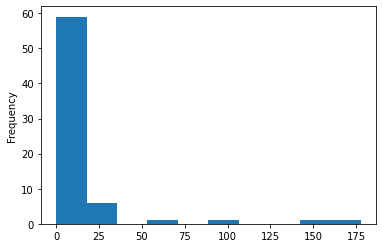

In [229]:
## Avg values in those weeks:
sj_train_features.precipitation_amt_mm.loc[(sj_train_features.index.get_level_values('weekofyear') >=7) & (sj_train_features.index.get_level_values('weekofyear') <=10)].plot.hist()

Most common for those weeks of the year is 0 mm precipitation. Furthermore those weeks are preceded and followed by weeks with 0 mm precipitation. So let's just fill them with 0.

In [230]:
sj_train_features['precipitation_amt_mm'] = sj_train_features['precipitation_amt_mm'].fillna(0)

In [231]:
for column in sj_train_features.columns.tolist():
    if column == 'week_start_date': continue
    n_nans=np.isnan(sj_train_features[column]).sum()
    if n_nans>0:
        print (column, n_nans)

reanalysis_sat_precip_amt_mm 3


In [232]:
sj_train_features.loc[np.isnan(sj_train_features['reanalysis_sat_precip_amt_mm'])]

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear                                                           
1992 7               1992-02-12  0.130500  0.130500  0.195743  0.178857   
     8               1992-02-19  0.184467  0.184467  0.194614  0.203057   
     9               1992-02-26  0.107050  0.081500  0.165243  0.163057   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear                                                
1992 7                            0.0             297.798571   
     8                            0.0             297.898571   
     9                            0.0             297.472857   

                 reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
year weekofyear                                                       
1992 7                      298.057143                   294.650000   
     8                      298.107143                   293.628571   
     9                      297.678571                   292.967143   

                 reanalysis_max_air_temp_k  ...  \
year weekofyear                             ...   
1992 7                               300.2  ...   
     8                               300.1  ...   
     9                               299.3  ...   

                 reanalysis_precip_amt_kg_per_m2  \
year weekofyear                                    
1992 7                                      20.1   
     8                                       4.4   
     9                                      14.4   

                 reanalysis_relative_humidity_percent  \
year weekofyear                                         
1992 7                                      82.875714   
     8                                      77.295714   
     9                                      76.037143   

                 reanalysis_sat_precip_amt_mm  \
year weekofyear                                 
1992 7                                    NaN   
     8                                    NaN   
     9                                    NaN   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
year weekofyear                                                             
1992 7                                       16.060000           2.200000   
     8                                       15.012857           2.585714   
     9                                       14.381429           2.414286   

                 station_avg_temp_c  station_diur_temp_rng_c  \
year weekofyear                                                
1992 7                    26.028571                 6.571429   
     8                    25.757143                 7.385714   
     9                    25.285714                 6.171429   

                 station_max_temp_c  station_min_temp_c  station_precip_mm  
year weekofyear                                                             
1992 7                         32.2                20.0                1.3  
     8                         33.9                21.7                8.9  
     9                         29.4                21.7               16.0  

[3 rows x 21 columns]

In [233]:
sj_train_features.loc[(sj_train_features.index.get_level_values('year')==1992) & (sj_train_features.index.get_level_values('weekofyear')<15)]

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear                                                           
1992 2               1992-01-08  0.100833  0.073575  0.138714  0.112786   
     3               1992-01-15  0.222400  0.229900  0.198457  0.199414   
     4               1992-01-22  0.122533  0.131050  0.188843  0.168871   
     5               1992-01-29  0.048300  0.048300  0.173671  0.191929   
     6               1992-02-05  0.101600  0.084600  0.111717  0.187957   
     7               1992-02-12  0.130500  0.130500  0.195743  0.178857   
     8               1992-02-19  0.184467  0.184467  0.194614  0.203057   
     9               1992-02-26  0.107050  0.081500  0.165243  0.163057   
     10              1992-03-04  0.182180  0.182180  0.191086  0.192857   
     11              1992-03-11  0.086850  0.090150  0.128000  0.155100   
     12              1992-03-18  0.053050  0.084050  0.141771  0.134514   
     13              1992-03-25  0.120821  0.120821  0.134843  0.106800   
     14              1992-04-01  0.099950  0.077650  0.193067  0.176900   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear                                                
1992 2                         200.85             297.912857   
     3                           3.12             297.338571   
     4                           0.00             297.091429   
     5                           0.00             297.420000   
     6                           0.00             296.920000   
     7                           0.00             297.798571   
     8                           0.00             297.898571   
     9                           0.00             297.472857   
     10                          0.00             297.651429   
     11                         23.22             297.634286   
     12                          0.00             297.947143   
     13                          0.00             297.218571   
     14                        122.27             297.982857   

                 reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
year weekofyear                                                       
1992 2                      298.121429                   294.457143   
     3                      297.485714                   294.467143   
     4                      297.335714                   293.021429   
     5                      297.550000                   292.718571   
     6                      297.128571                   292.617143   
     7                      298.057143                   294.650000   
     8                      298.107143                   293.628571   
     9                      297.678571                   292.967143   
     10                     297.800000                   293.317143   
     11                     297.785714                   293.540000   
     12                     298.150000                   293.708571   
     13                     297.428571                   293.578571   
     14                     298.071429                   293.884286   

                 reanalysis_max_air_temp_k  ...  \
year weekofyear                             ...   
1992 2                               300.4  ...   
     3                               300.2  ...   
     4                               299.5  ...   
     5                               299.3  ...   
     6                               300.7  ...   
     7                               300.2  ...   
     8                               300.1  ...   
     9                               299.3  ...   
     10                              299.8  ...   
     11                              299.6  ...   
     12                              300.4  ...   
     13                              300.3  ...   
     14                              300.2  ...   

                 reanalysis_precip_amt_kg_per_m2  \
year weekofyear                              

Same for this variable as well, which is also probably correlated with the previous one on precipitation. So lets just set those 3 values to 0 also:

In [234]:
sj_train_features['reanalysis_sat_precip_amt_mm'] = sj_train_features['reanalysis_sat_precip_amt_mm'].fillna(0)

At this point we should have no NaNs left in sj!

In [235]:
# Null check
pd.isnull(sj_train_features).any()

week_start_date                          False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_temp_c                       False
station_precip_mm                        False
dtype: bool

In [236]:
pd.isnull(sj_train_labels).any()

total_cases    False
dtype: bool

So now lets repeat the cleaning for the iq df.

In [237]:
pd.isnull(iq_train_features).any()

week_start_date                          False
ndvi_ne                                   True
ndvi_nw                                   True
ndvi_se                                   True
ndvi_sw                                   True
precipitation_amt_mm                      True
reanalysis_air_temp_k                     True
reanalysis_avg_temp_k                     True
reanalysis_dew_point_temp_k               True
reanalysis_max_air_temp_k                 True
reanalysis_min_air_temp_k                 True
reanalysis_precip_amt_kg_per_m2           True
reanalysis_relative_humidity_percent      True
reanalysis_sat_precip_amt_mm              True
reanalysis_specific_humidity_g_per_kg     True
reanalysis_tdtr_k                         True
station_avg_temp_c                        True
station_diur_temp_rng_c                   True
station_max_temp_c                        True
station_min_temp_c                        True
station_precip_mm                         True
dtype: bool

In [238]:
for column in iq_train_features.columns.tolist():
    if column == 'week_start_date': continue
    n_nans=np.isnan(iq_train_features[column]).sum()
    if n_nans>0:
        print (column, n_nans)

ndvi_ne 3
ndvi_nw 3
ndvi_se 3
ndvi_sw 3
precipitation_amt_mm 4
reanalysis_air_temp_k 4
reanalysis_avg_temp_k 4
reanalysis_dew_point_temp_k 4
reanalysis_max_air_temp_k 4
reanalysis_min_air_temp_k 4
reanalysis_precip_amt_kg_per_m2 4
reanalysis_relative_humidity_percent 4
reanalysis_sat_precip_amt_mm 4
reanalysis_specific_humidity_g_per_kg 4
reanalysis_tdtr_k 4
station_avg_temp_c 37
station_diur_temp_rng_c 37
station_max_temp_c 14
station_min_temp_c 8
station_precip_mm 16


Lets start with the ndvi:


In [239]:
iq_train_features.loc[np.isnan(iq_train_features.ndvi_ne)]

,,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
year,weekofyear,,,,,,,,,,,,,,,,,,,,,
2002,5,2002-01-29,NaN,NaN,NaN,NaN,59.4,296.858571,297.9,296.137143,304.2,...,43.12,96.267143,59.4,17.69,5.228571,26.3,9.7,32.5,20.8,120.2
2005,53,2005-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010,53,2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's drop the the 2 entries where they are all full of NaNs:

In [240]:
iq_train_features.drop(iq_train_features[np.isnan(iq_train_features.ndvi_ne) & np.isnan(iq_train_features.precipitation_amt_mm)].index, inplace = True)


/opt/anaconda3/envs/track_ML/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [241]:
iq_train_features.loc[np.isnan(iq_train_features.ndvi_ne)]

,,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
year,weekofyear,,,,,,,,,,,,,,,,,,,,,
2002,5,2002-01-29,NaN,NaN,NaN,NaN,59.4,296.858571,297.9,296.137143,304.2,...,43.12,96.267143,59.4,17.69,5.228571,26.3,9.7,32.5,20.8,120.2


In [242]:
iq_train_features['ndvi_ne'].fillna(method='ffill',inplace=True)
iq_train_features['ndvi_nw'].fillna(method='ffill',inplace=True)
iq_train_features['ndvi_se'].fillna(method='ffill',inplace=True)
iq_train_features['ndvi_sw'].fillna(method='ffill',inplace=True)

/opt/anaconda3/envs/track_ML/lib/python3.7/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


Done with NDVIs, move on to next vars.

In [243]:
for column in iq_train_features.columns.tolist():
    if column == 'week_start_date': continue
    n_nans=np.isnan(iq_train_features[column]).sum()
    if n_nans>0:
        print (column, n_nans)

precipitation_amt_mm 2
reanalysis_air_temp_k 2
reanalysis_avg_temp_k 2
reanalysis_dew_point_temp_k 2
reanalysis_max_air_temp_k 2
reanalysis_min_air_temp_k 2
reanalysis_precip_amt_kg_per_m2 2
reanalysis_relative_humidity_percent 2
reanalysis_sat_precip_amt_mm 2
reanalysis_specific_humidity_g_per_kg 2
reanalysis_tdtr_k 2
station_avg_temp_c 35
station_diur_temp_rng_c 35
station_max_temp_c 12
station_min_temp_c 6
station_precip_mm 14


In [244]:
iq_train_features.loc[np.isnan(iq_train_features.precipitation_amt_mm)]

,,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
year,weekofyear,,,,,,,,,,,,,,,,,,,,,
2004,1,2004-01-01,0.202571,0.198967,0.244557,0.187957,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,1,2009-01-01,0.151286,0.161686,0.153271,0.119443,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Looks like we can just drop these 2 rows.

In [245]:
iq_train_features = iq_train_features.dropna(subset=['precipitation_amt_mm'])

In [246]:
for column in iq_train_features.columns.tolist():
    if column == 'week_start_date': continue
    n_nans=np.isnan(iq_train_features[column]).sum()
    if n_nans>0:
        print (column, n_nans)

station_avg_temp_c 33
station_diur_temp_rng_c 33
station_max_temp_c 10
station_min_temp_c 4
station_precip_mm 12


Lets attack those missing temp values.

In [247]:
iq_train_features.loc[np.isnan(iq_train_features.station_avg_temp_c)]

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear                                                           
2001 20              2001-05-14  0.315343  0.319650  0.262700  0.303486   
     26              2001-06-25  0.192300  0.275286  0.316457  0.325414   
2002 18              2002-04-30  0.170357  0.141829  0.197729  0.257071   
     34              2002-08-20  0.345425  0.313540  0.295050  0.309267   
     44              2002-10-29  0.329086  0.286214  0.294057  0.315929   
2003 8               2003-02-19  0.126257  0.135514  0.103657  0.133714   
2004 22              2004-05-27  0.190314  0.077843  0.193171  0.102329   
     31              2004-07-29  0.208900  0.155500  0.220300  0.254257   
     32              2004-08-05  0.248900  0.265957  0.218529  0.237557   
     33              2004-08-12  0.191071  0.227000  0.168529  0.295700   
     34              2004-08-19  0.393129  0.328643  0.276771  0.388514   
     35              2004-08-26  0.311300  0.260929  0.233014  0.299786   
     50              2004-12-09  0.323429  0.309514  0.275829  0.335900   
2005 20              2005-05-21  0.270086  0.173757  0.210457  0.229743   
     22              2005-06-04  0.378286  0.369371  0.363186  0.361243   
     33              2005-08-20  0.266986  0.293929  0.336000  0.292486   
     36              2005-09-10  0.335429  0.200714  0.322886  0.309143   
     37              2005-09-17  0.239429  0.214871  0.239043  0.227600   
     45              2005-11-12  0.393800  0.298629  0.401986  0.410371   
2006 1               2006-01-08  0.199514  0.239343  0.227657  0.215500   
     3               2006-01-22  0.174300  0.133643  0.111757  0.194429   
     5               2006-02-05  0.379114  0.305329  0.345971  0.371571   
     50              2006-12-17  0.378500  0.302033  0.349229  0.414786   
     51              2006-12-24  0.327820  0.261920  0.381467  0.352950   
2008 4               2008-01-22  0.277971  0.324929  0.221914  0.295671   
     12              2008-03-18  0.238333  0.232729  0.123943  0.200071   
     24              2008-06-10  0.293743  0.264367  0.246629  0.291957   
     25              2008-06-17  0.224029  0.175471  0.265657  0.245214   
     26              2008-06-24  0.197043  0.277983  0.213943  0.265614   
     27              2008-07-01  0.304829  0.233671  0.248914  0.255814   
     28              2008-07-08  0.153850  0.149586  0.329443  0.132886   
     29              2008-07-15  0.232386  0.213957  0.220300  0.198429   
     40              2008-09-30  0.393086  0.378271  0.343700  0.404843   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear                                                
2001 20                         74.08             297.297143   
     26                          1.22             294.845714   
2002 18                         60.05             297.408571   
     34                         31.71             296.184286   
     44                         89.77             298.518571   
2003 8                          25.03             298.567143   
2004 22                         35.43             297.305714   
     31                         85.96             296.017143   
     32                         29.82             297.517143   
     33                         18.44             296.530000   
     34                         23.78             297.820000   
     35                         42.86             298.142857   
     50                         70.04             297.787143   
2005 20                         56.22             297.532857   
     22                         61.75             298.434286   
     33                         17.85             299.605714   
     36                         36.98             300.058571   
     37                         18.66             298.880000   
     45                         75.36             298.600000   
2006 1                          38.78         

All those missing values seem mostly non-continuous. We can just fill them forward.

In [248]:
iq_train_features['station_avg_temp_c'].fillna(method='ffill',inplace=True)
iq_train_features['station_diur_temp_rng_c'].fillna(method='ffill',inplace=True)

In [249]:
for column in iq_train_features.columns.tolist():
    if column == 'week_start_date': continue
    n_nans=np.isnan(iq_train_features[column]).sum()
    if n_nans>0:
        print (column, n_nans)

station_max_temp_c 10
station_min_temp_c 4
station_precip_mm 12


In [250]:
iq_train_features.loc[np.isnan(iq_train_features.station_max_temp_c)]

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear                                                           
2004 34              2004-08-19  0.393129  0.328643  0.276771  0.388514   
     50              2004-12-09  0.323429  0.309514  0.275829  0.335900   
2005 36              2005-09-10  0.335429  0.200714  0.322886  0.309143   
     37              2005-09-17  0.239429  0.214871  0.239043  0.227600   
2008 24              2008-06-10  0.293743  0.264367  0.246629  0.291957   
     25              2008-06-17  0.224029  0.175471  0.265657  0.245214   
     26              2008-06-24  0.197043  0.277983  0.213943  0.265614   
     27              2008-07-01  0.304829  0.233671  0.248914  0.255814   
     28              2008-07-08  0.153850  0.149586  0.329443  0.132886   
     29              2008-07-15  0.232386  0.213957  0.220300  0.198429   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear                                                
2004 34                         23.78             297.820000   
     50                         70.04             297.787143   
2005 36                         36.98             300.058571   
     37                         18.66             298.880000   
2008 24                         13.27             296.187143   
     25                        111.18             296.742857   
     26                         89.88             296.458571   
     27                          0.00             296.542857   
     28                          0.00             296.545714   
     29                         62.84             296.078571   

                 reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
year weekofyear                                                       
2004 34                     299.985714                   293.421429   
     50                     298.835714                   296.574286   
2005 36                     301.214286                   294.005714   
     37                     299.807143                   295.658571   
2008 24                     297.364286                   293.891429   
     25                     297.650000                   295.934286   
     26                     297.250000                   295.192857   
     27                     297.807143                   293.830000   
     28                     297.478571                   293.594286   
     29                     297.407143                   294.691429   

                 reanalysis_max_air_temp_k  ...  \
year weekofyear                             ...   
2004 34                              308.3  ...   
     50                              305.8  ...   
2005 36                              309.3  ...   
     37                              307.3  ...   
2008 24                              305.8  ...   
     25                              304.4  ...   
     26                              304.8  ...   
     27                              304.9  ...   
     28                              305.9  ...   
     29                              304.6  ...   

                 reanalysis_precip_amt_kg_per_m2  \
year weekofyear                                    
2004 34                                     7.90   
     50                                    91.00   
2005 36                                     4.20   
     37                                    35.30   
2008 24                                    12.90   
     25                                    57.87   
     26                                    61.80   
     27                                     9.40   
     28                                     7.47   
     29                                    27.33   

                 reanalysis_relative_humidity_percent  \
year weekofyear                                         
2004 34                                     78.481429   
     50                                     93.938571   
2005 36                    

Lets look at that continuous period in 2008, see if we can be more smart in replacing that.

In [251]:
iq_train_features.loc[(iq_train_features.index.get_level_values('year')==2008) & (iq_train_features.index.get_level_values('weekofyear')>15) & (iq_train_features.index.get_level_values('weekofyear')<40 )]

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear                                                           
2008 16              2008-04-15  0.302614  0.244671  0.296314  0.328757   
     17              2008-04-22  0.270600  0.371314  0.344229  0.283071   
     18              2008-04-29  0.061729  0.133900  0.094714  0.117843   
     19              2008-05-06  0.136157  0.163157  0.139157  0.134557   
     20              2008-05-13  0.196386  0.296320  0.264157  0.225586   
     21              2008-05-20  0.221017  0.235317  0.180443  0.199471   
     22              2008-05-27  0.122450  0.157100  0.086000  0.103314   
     23              2008-06-03  0.195186  0.157714  0.184429  0.133614   
     24              2008-06-10  0.293743  0.264367  0.246629  0.291957   
     25              2008-06-17  0.224029  0.175471  0.265657  0.245214   
     26              2008-06-24  0.197043  0.277983  0.213943  0.265614   
     27              2008-07-01  0.304829  0.233671  0.248914  0.255814   
     28              2008-07-08  0.153850  0.149586  0.329443  0.132886   
     29              2008-07-15  0.232386  0.213957  0.220300  0.198429   
     30              2008-07-22  0.327017  0.209117  0.283767  0.309550   
     31              2008-07-29  0.354800  0.346550  0.267417  0.392117   
     32              2008-08-05  0.200200  0.251386  0.211343  0.199729   
     33              2008-08-12  0.430371  0.433014  0.436914  0.465729   
     34              2008-08-19  0.283300  0.304471  0.274457  0.380500   
     35              2008-08-26  0.318186  0.319767  0.308171  0.323600   
     36              2008-09-02  0.339800  0.369100  0.288800  0.309233   
     37              2008-09-09  0.231900  0.276250  0.261200  0.232783   
     38              2008-09-16  0.216800  0.277333  0.208933  0.336267   
     39              2008-09-23  0.414950  0.363429  0.322400  0.400686   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear                                                
2008 16                         79.74             297.447143   
     17                         42.05             296.760000   
     18                         42.12             298.072857   
     19                         50.50             295.975714   
     20                         30.08             294.850000   
     21                         45.69             296.268571   
     22                         72.04             296.741429   
     23                         30.09             296.400000   
     24                         13.27             296.187143   
     25                        111.18             296.742857   
     26                         89.88             296.458571   
     27                          0.00             296.542857   
     28                          0.00             296.545714   
     29                         62.84             296.078571   
     30                         52.36             296.545714   
     31                         44.63             297.044286   
     32                         32.45             297.310000   
     33                         26.03             297.214286   
     34                         12.88             299.228571   
     35                         58.20             298.574286   
     36                         34.59             298.531429   
     37                         86.14             296.921429   
     38                         65.43             297.588571   
     39                         61.38             297.660000   

                 reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
year weekofyear                                                       
2008 16                     298.664286                   295.935714   
     17                     297.414286                   296.382857   
     18                     299.414286                   296.741429   
     19                     296.871429       

<AxesSubplot:xlabel='year,weekofyear'>

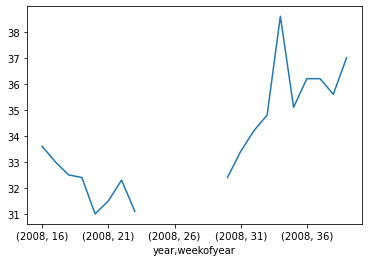

In [252]:
iq_train_features.loc[(iq_train_features.index.get_level_values('year')==2008) & (iq_train_features.index.get_level_values('weekofyear')>15) & (iq_train_features.index.get_level_values('weekofyear')<40 ), 'station_max_temp_c'].plot()

Lets just set the missing values with 32:

In [253]:
iq_train_features.loc[(iq_train_features.index.get_level_values('year')==2008) & np.isnan(iq_train_features.station_max_temp_c), 'station_max_temp_c'] = 32

<AxesSubplot:xlabel='year,weekofyear'>

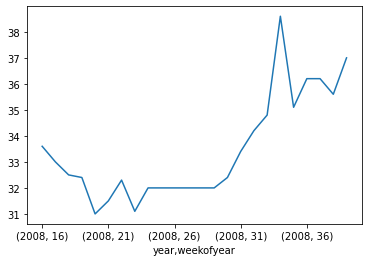

In [254]:
iq_train_features.loc[(iq_train_features.index.get_level_values('year')==2008) & (iq_train_features.index.get_level_values('weekofyear')>15) & (iq_train_features.index.get_level_values('weekofyear')<40 ), 'station_max_temp_c'].plot()

For the remaining ones we can ffill:

In [255]:
iq_train_features['station_max_temp_c'].fillna(method='ffill',inplace=True)

Next for the station_min_temp:

In [256]:
iq_train_features.loc[np.isnan(iq_train_features.station_min_temp_c)]

,,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
year,weekofyear,,,,,,,,,,,,,,,,,,,,,
2001,20,2001-05-14,0.315343,0.319650,0.262700,0.303486,74.08,297.297143,298.307143,296.990000,305.6,...,80.3,98.341429,74.08,18.640000,5.642857,26.6,8.80,32.5,NaN,0.0
2004,50,2004-12-09,0.323429,0.309514,0.275829,0.335900,70.04,297.787143,298.835714,296.574286,305.8,...,91.0,93.938571,70.04,18.207143,6.500000,27.9,11.00,34.1,NaN,9.9
2005,37,2005-09-17,0.239429,0.214871,0.239043,0.227600,18.66,298.880000,299.807143,295.658571,307.3,...,35.3,83.730000,18.66,17.222857,9.928571,26.8,10.25,35.2,NaN,1.3
2006,50,2006-12-17,0.378500,0.302033,0.349229,0.414786,157.75,298.158571,299.071429,297.351429,304.4,...,63.0,95.875714,157.75,19.111429,6.400000,28.4,8.80,33.8,NaN,NaN


In [257]:
iq_train_features['station_min_temp_c'].fillna(method='ffill',inplace=True)

In [258]:
for column in iq_train_features.columns.tolist():
    if column == 'week_start_date': continue
    n_nans=np.isnan(iq_train_features[column]).sum()
    if n_nans>0:
        print (column, n_nans)

station_precip_mm 12


In [259]:
iq_train_features.loc[np.isnan(iq_train_features.station_precip_mm)]

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear                                                           
2000 47              2000-11-25  0.169983  0.289300  0.300983  0.170917   
2001 32              2001-08-06  0.200757  0.237729  0.223643  0.204357   
2002 16              2002-04-16  0.269350  0.212157  0.188929  0.194943   
2005 39              2005-10-01  0.405417  0.428771  0.370600  0.421086   
2006 50              2006-12-17  0.378500  0.302033  0.349229  0.414786   
     51              2006-12-24  0.327820  0.261920  0.381467  0.352950   
2007 27              2007-07-02  0.181443  0.269229  0.193457  0.209943   
2008 1               2008-01-01  0.191471  0.155414  0.176014  0.187243   
2009 23              2009-06-04  0.114000  0.092443  0.097471  0.126286   
     32              2009-08-06  0.395000  0.352733  0.484286  0.401914   
2010 1               2010-01-08  0.124571  0.179129  0.163843  0.135471   
     14              2010-04-09  0.242843  0.272757  0.202271  0.260114   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear                                                
2000 47                         55.91             300.872857   
2001 32                          0.00             298.537143   
2002 16                        109.49             297.764286   
2005 39                         29.80             301.175714   
2006 50                        157.75             298.158571   
     51                        111.48             297.680000   
2007 27                          1.59             296.828571   
2008 1                          19.95             299.277143   
2009 23                         42.22             296.125714   
     32                          9.79             297.370000   
2010 1                          27.04             299.264286   
     14                         93.76             299.115714   

                 reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
year weekofyear                                                       
2000 47                     301.914286                   293.060000   
2001 32                     300.135714                   291.387143   
2002 16                     298.921429                   296.310000   
2005 39                     302.928571                   293.752857   
2006 50                     299.071429                   297.351429   
     51                     298.985714                   296.725714   
2007 27                     298.114286                   292.177143   
2008 1                      300.535714                   294.668571   
2009 23                     296.778571                   295.267143   
     32                     298.878571                   294.824286   
2010 1                      300.521429                   294.530000   
     14                     300.271429                   298.161429   

                 reanalysis_max_air_temp_k  ...  \
year weekofyear                             ...   
2000 47                              311.1  ...   
2001 32                              308.7  ...   
2002 16                              305.0  ...   
2005 39                              314.0  ...   
2006 50                              304.4  ...   
     51                              306.7  ...   
2007 27                              305.8  ...   
2008 1                               308.2  ...   
2009 23                              302.5  ...   
     32                              307.9  ...   
2010 1                               308.6  ...   
     14                              308.4  ...   

                 reanalysis_precip_amt_kg_per_m2  \
year weekofyear                                    
2000 47                                    11.20   
2001 32                                     0.20   
2002 16                                    49.80   
2005 39                                     4.20   
2006 50                                    63.

Great, looks like we can just ffill these:

In [260]:
iq_train_features['station_precip_mm'].fillna(method='ffill',inplace=True)

In [261]:
pd.isnull(iq_train_features).any()

week_start_date                          False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_temp_c                       False
station_precip_mm                        False
dtype: bool

In [262]:
pd.isnull(iq_train_labels).any()

total_cases    False
dtype: bool

**All done! No NaNs left in our dataframes.**

<a id='reindex'></a>

## Re-indexing with Datetime object

Changing the uncomfortable multiindex object with a single datetime object.

In [263]:
def reindex_df(df, woy_column=True):
    df['year']=df.index.get_level_values('year').values
    df['weekofyear']=(df.index.get_level_values('weekofyear').values)
    df['dayofyear']=(7*df.index.get_level_values('weekofyear').values)

    ### for the datetime object we need zero-padding:
    #df['weekofyear']=df['weekofyear'].astype(str).str.pad(2,fillchar='0')
    #df['dayofyear']=df['dayofyear'].astype(str).str.pad(3,fillchar='0')

    df['datetime'] = pd.to_datetime(np.asarray(df['year'], dtype='datetime64[Y]')-1970 + (np.asarray(df['dayofyear'], dtype='timedelta64[D]')-1) )
    df.set_index('datetime', inplace=True)
    
    ## Drop the year, dayofyear columns
    df.drop('year', axis=1, inplace=True)
    df.drop('dayofyear', axis=1, inplace=True)
    
    ## For a features df we want to keep the weekofyear, it should be a useful feature to catch any seasonality.
    ## But not if it is a df of the labels.
    if not woy_column:
        df.drop('weekofyear', axis=1, inplace=True)
        
    
    return df


In [264]:
sj_train_features.index

MultiIndex([(1990, 18),
            (1990, 19),
            (1990, 20),
            (1990, 21),
            (1990, 22),
            (1990, 23),
            (1990, 24),
            (1990, 25),
            (1990, 26),
            (1990, 27),
            ...
            (2008,  8),
            (2008,  9),
            (2008, 10),
            (2008, 11),
            (2008, 12),
            (2008, 13),
            (2008, 14),
            (2008, 15),
            (2008, 16),
            (2008, 17)],
           names=['year', 'weekofyear'], length=930)

In [275]:
if sj_train_features.index.name != 'datetime':
    sj_train_features = reindex_df(sj_train_features, woy_column=True)
    iq_train_features = reindex_df(iq_train_features, woy_column=True)

In [276]:
if sj_train_labels.index.name!='datetime':
    sj_train_labels = reindex_df(sj_train_labels,woy_column=False)
    iq_train_labels = reindex_df(iq_train_labels, woy_column=False)

In [277]:
iq_train_features

,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,weekofyear
datetime,,,,,,,,,,,,,,,,,,,,,
2000-06-30,2000-07-01,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,298.450000,295.184286,307.3,...,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0,26
2000-07-07,2000-07-08,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,298.428571,295.358571,306.6,...,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6,27
2000-07-14,2000-07-15,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,297.392857,295.622857,304.5,...,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1,28
2000-07-21,2000-07-22,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,296.228571,292.797143,303.6,...,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0,29
2000-07-28,2000-07-29,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,297.635714,293.957143,307.0,...,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-05-27,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,296.825714,309.7,...,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,21
2010-06-03,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,296.452857,308.5,...,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,22
2010-06-10,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,305.5,...,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,23


<a id='feature_engineering'></a>

## Some feature engineering

Let's try to improve the features we use.  

First let's add the last week's case count as predictive feature:

In [78]:
sj_train_features['past_week_cases'] = sj_train_labels.total_cases.shift(1)
iq_train_features['past_week_cases'] = iq_train_labels.total_cases.shift(1)

/opt/anaconda3/envs/track_ML/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [83]:
sj_train_features['past_week_cases']

datetime
1990-05-06    4.0
1990-05-13    4.0
1990-05-20    5.0
1990-05-27    4.0
1990-06-03    3.0
             ... 
2008-03-31    3.0
2008-04-07    4.0
2008-04-14    3.0
2008-04-21    1.0
2008-04-28    3.0
Name: past_week_cases, Length: 930, dtype: float64

In [89]:
iq_train_features['past_week_cases']

datetime
2000-06-30    NaN
2000-07-07    0.0
2000-07-14    0.0
2000-07-21    0.0
2000-07-28    0.0
             ... 
2010-05-27    6.0
2010-06-03    5.0
2010-06-10    8.0
2010-06-17    1.0
2010-06-24    1.0
Name: past_week_cases, Length: 516, dtype: float64

In [90]:
## Let's fill those first entries with a guess for the previous week
sj_train_features.past_week_cases[0]=4
iq_train_features.past_week_cases[0]=0

/opt/anaconda3/envs/track_ML/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/track_ML/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [82]:
len(sj_train_features)

930

In [84]:
sj_train_features.head()

,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,weekofyear,past_week_cases
datetime,,,,,,,,,,,,,,,,,,,,,
1990-05-06,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,...,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,18,4.0
1990-05-13,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,...,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,19,4.0
1990-05-20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,...,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,20,5.0
1990-05-27,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,...,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,21,4.0
1990-06-03,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,...,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,22,3.0


Let's plot the total cases, see if they exhibit any seasonality. That would give us a better understanding of how to approach the problem.

In [85]:
df=sj_train_features

df.past_week_cases

datetime
1990-05-06    4.0
1990-05-13    4.0
1990-05-20    5.0
1990-05-27    4.0
1990-06-03    3.0
             ... 
2008-03-31    3.0
2008-04-07    4.0
2008-04-14    3.0
2008-04-21    1.0
2008-04-28    3.0
Name: past_week_cases, Length: 930, dtype: float64

/opt/anaconda3/envs/track_ML/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='datetime'>

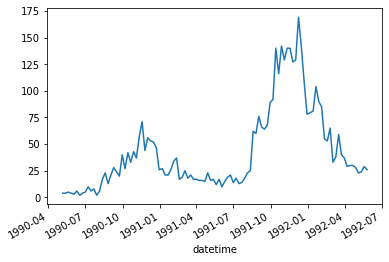

In [86]:
df.past_week_cases['1990-01':'1992-05'].plot()

/opt/anaconda3/envs/track_ML/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='datetime'>

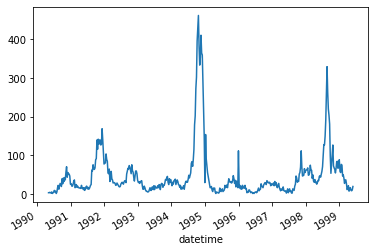

In [91]:
df.past_week_cases['1990-01':'1999-05'].plot()

Definitely a seasonality there, with cases spiking towards the end of the year, it appears.  


Let's see if the seasonality and pattern looks similar between the two cities:

/opt/anaconda3/envs/track_ML/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='datetime'>

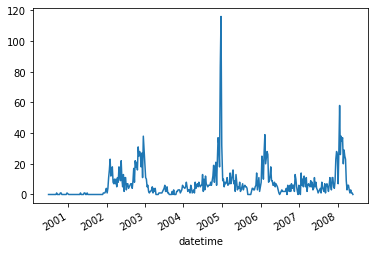

In [92]:
iq_train_features.past_week_cases['2000-01':'2008-05'].plot()

/opt/anaconda3/envs/track_ML/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='datetime'>

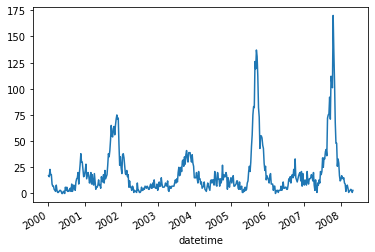

In [93]:
sj_train_features.past_week_cases['2000-01':'2008-05'].plot()

### TO DO:
* Drop features that have very little predictive power.
    * Especially if highly correlated to other features that they are practically duplicate and offer very little, eg the ndvi's.
* Consider joining the df's for the two cities.
    * Maybe if the two cities are similar enough maybe the climatological data would allow inferences independent of city.
    * Or perhaps common training could teach some predictive qualities, but then do some transfer learning on the separate df's for the prediction of each city. That is, do some global training, then bi-furcate the models and their predictions.

<a id='model'></a>

## Developing a predictive model

There are _a lot_ of climate variables here, but the first thing that we'll note is that the `week_start_date` is included in the feature set. This makes it easier for competitors to create time based features, but for this first-pass model, we'll drop that column since we shouldn't use it as a feature in our model.

In [96]:
# Remove `week_start_date` string.
sj_train_features.drop('week_start_date', axis=1, inplace=True)
iq_train_features.drop('week_start_date', axis=1, inplace=True)

/opt/anaconda3/envs/track_ML/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,



Our target variable, `total_cases` is a non-negative integer, which means we're looking to make some **count predictions**. Standard regression techniques for this type of prediction include

1. Poisson regression
2. Negative binomial regression

Which techniqe will perform better depends on many things, but the choice between Poisson regression and negative binomial regression is pretty straightforward. Poisson regression fits according to the assumption that the mean and variance of the population distributiona are equal. When they aren't, specifically when the variance is much larger than the mean, the negative binomial approach is better. Why? It isn't magic. The negative binomial regression simply lifts the assumption that the population mean and variance are equal, allowing for a larger class of possible models. In fact, from this perspective, the Poisson distribution is but a special case of the negative binomial distribution.

Let's see how our labels are distributed!

In [97]:
print('San Juan')
print('mean: ', sj_train_labels.mean()[0])
print('var :', sj_train_labels.var()[0])

print('\nIquitos')
print('mean: ', iq_train_labels.mean()[0])
print('var :', iq_train_labels.var()[0])

San Juan
mean:  34.18055555555556
var : 2640.045439691045

Iquitos
mean:  7.565384615384615
var : 115.8955239365642


It's looking like a negative-binomial sort of day in these parts.

array([[<AxesSubplot:title={'center':'total_cases'}>]], dtype=object)

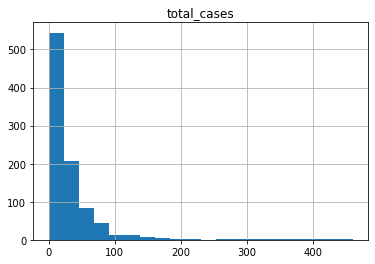

In [98]:
sj_train_labels.hist(bins=20)

array([[<AxesSubplot:title={'center':'total_cases'}>]], dtype=object)

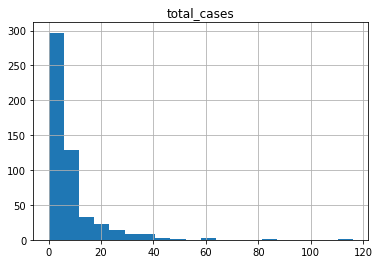

In [99]:
iq_train_labels.hist(bins=20)

`variance  >>  mean` suggests `total_cases` can be described by a negative binomial distribution, so we'll use a negative binomial regression below.

## Which inputs strongly correlate with `total_cases`?

Our next step in this process will be to select a subset of features to include in our regression. Our primary purpose here is to get a better understanding of the problem domain rather than eke out the last possible bit of predictive accuracy. The first thing we will do is to add the `total_cases` to our dataframe, and then look at the correlation of that variable with the climate variables.

In [100]:
sj_train_features['total_cases'] = sj_train_labels.total_cases
iq_train_features['total_cases'] = iq_train_labels.total_cases

/opt/anaconda3/envs/track_ML/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Compute the data correlation matrix.

In [101]:
# compute the correlations
sj_correlations = sj_train_features.corr()
iq_correlations = iq_train_features.corr()

Text(0.5, 1.0, 'San Juan Variable Correlations')

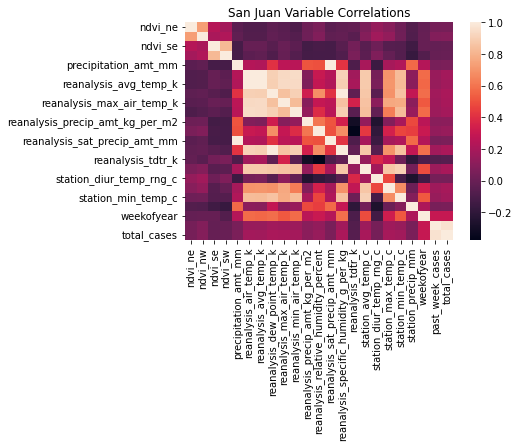

In [102]:
# plot san juan
sj_corr_heat = sns.heatmap(sj_correlations)
plt.title('San Juan Variable Correlations')

Text(0.5, 1.0, 'Iquitos Variable Correlations')

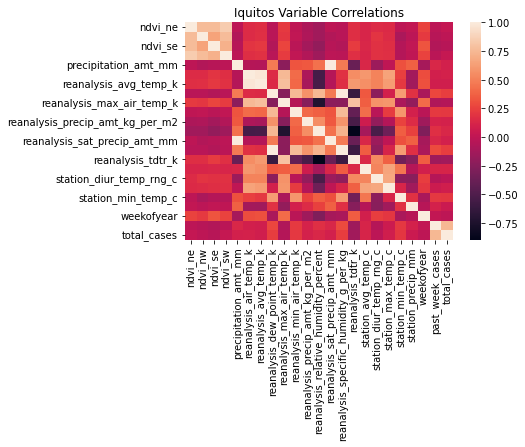

In [103]:
# plot iquitos
iq_corr_heat = sns.heatmap(iq_correlations)
plt.title('Iquitos Variable Correlations')

Many of the temperature data are strongly correlated, which is expected. But the `total_cases` variable doesn't have many obvious strong correlations.

Interestingly, `total_cases` seems to only have weak correlations with other variables. Many of the climate variables are much more strongly correlated. Interestingly, the vegetation index also only has weak correlation with other variables. These correlations may give us some hints as to how to improve our model that we'll talk about later in this post. For now, let's take a `sorted` look at `total_cases` correlations.

<AxesSubplot:>

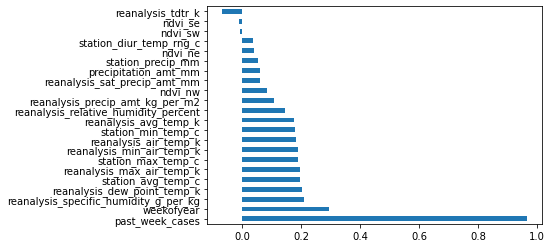

In [104]:
# San Juan
(sj_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

<AxesSubplot:>

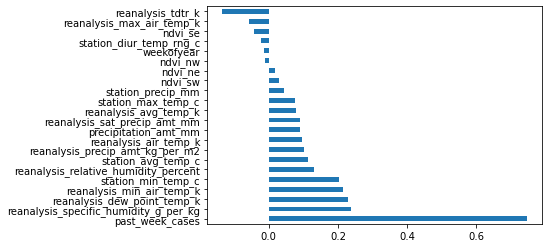

In [105]:
# Iquitos
(iq_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

### A few observations

#### The wetter the better
* The correlation strengths differ for each city, but it looks like `reanalysis_specific_humidity_g_per_kg` and `reanalysis_dew_point_temp_k` are the most strongly correlated with `total_cases`. This makes sense: we know mosquitos thrive _wet_ climates, the wetter the better!

#### Hot and heavy
* As we all know, "cold and humid" is not a thing. So it's not surprising that as minimum temperatures, maximum temperatures, and average temperatures rise, the `total_cases` of dengue fever tend to rise as well.

#### Sometimes it rains, so what
* Interestingly, the `precipitation` measurements bear little to no correlation to `total_cases`, despite strong correlations to the `humidity` measurements, as evident by the heatmaps above.

### This is just a first pass

Precisely _none_ of these correlations are very strong. Of course, that doesn't mean that some **feature engineering wizardry** can't put us in a better place **(`standing_water` estimate, anyone?)**. Also, it's always useful to keep in mind that **life isn't linear**, but out-of-the-box correlation measurement is – or at least, it measures linear dependence.

Nevertheless, for this benchmark we'll focus on the linear __wetness__ trend we see above, and reduce our inputs to 

#### A few good variables

* `reanalysis_specific_humidity_g_per_kg`
* `reanalysis_dew_point_temp_k`
* `station_avg_temp_c`
* `station_min_temp_c`

### TO DO:
* Add some more variables in the model input, still excluding those that show very little correlation.
* Feature engineering
    * Something like standing water is clever. Go back to previous weeks and aggregate precipitation and other inputs to have an estimate for standing water in every week.
    * Other similar measures? Eg how hot has it been on average over the past 1-2 weeks?
    * The relevant time scale for those should be the life cycle for mosquitos, which I should look up.
        * OTOH, a RNN should automatically take into account delayed effects from previous time steps, and even combination of input features.

<a id='process_data'></a>

## Pre-processing the data

Before we go into model building, let's write a function to standardize all of the preprocessing we've done above from start to finish. This will make our lives easier, since it needs to be applied to the test set and the traning set before we make our predictions.  

We won't be able to read the training data from scratch and apply standardized procedures, since everything we done above was very specialized. So expect to read df's that have mostly had their NaN values processed already.

In [201]:
## This is 
def preprocess_data(df=None, data_path=None, df_labels=None, labels_path=None,
                   city=None # expecting 'sj' or 'iq' here
                   ):
    if (df is None):
        if data_path is None: 
            print('Need a df object or path')
            return 0
        # load data and set index to city, year, weekofyear
        df = pd.read_csv(data_path, index_col=[0, 1, 2])
    
    # select features we want
    features = ['reanalysis_specific_humidity_g_per_kg', 
                'reanalysis_dew_point_temp_k', 
                'reanalysis_max_air_temp_k', 
                'reanalysis_min_air_temp_k', 
                'reanalysis_sat_precip_amt_mm', 
                'reanalysis_precip_amt_kg_per_m2', 
                'station_avg_temp_c', 
                'station_min_temp_c',
                'ndvi_se']
    df = df[features]
    
    # fill missing values
    df.fillna(method='ffill', inplace=True)

    # add labels to dataframe
    if (df_labels is None):
        if (labels_path is not None):
            df_labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
    if (df_labels is not None):
        df = df.join(df_labels)
    
    # separate san juan and iquitos
    if city is not None:
        df = df.loc[city]
        
    
    return df

In [325]:
def normalize_df(df):
    df_mean = df.mean()
    df_std = df.std()

    df_norm = (df - df_mean) / df_std
    
    return df_norm

In [385]:
### This function processes df's that already have had some pre-processing done
def process_df(in_df, return_woy=True):
    ## We will drop columns and reindex, 
    ## so lets avoid losing that information from the original copy
    df=in_df.copy() 
    
    if 'total_cases' in df.columns:
        ## The labels are contained in this df, so it is used for training.
        ## Create the past_week_cases column that we need.
        if 'past_week_cases' not in df.columns:
            df['past_week_cases'] = df.total_cases.shift(1)
            df['past_week_cases'][0]=0
            df.drop('total_cases', axis=1, inplace=True)
    else:
        ## Otherwise, if a past_week_cases column doesn't exist already, create an empty one
        if 'past_week_cases' not in df.columns:
            df['past_week_cases']=0

    ## Re-index if hasn't been done already
    if df.index.name!='datetime':
        df = reindex_df(df, woy_column=return_woy)
    
    if 'week_start_date' in df.columns:
        df.drop('week_start_date', axis=1, inplace=True)
    
    
    ## Only select the features that will be useful for prediction, drop the rest
    if return_woy: 
        ## only do this selection for a features df
        selected_features = [
            'reanalysis_specific_humidity_g_per_kg', 
            'reanalysis_dew_point_temp_k', 
            'reanalysis_max_air_temp_k', 
            'reanalysis_sat_precip_amt_mm', 
            'reanalysis_relative_humidity_percent',
            'reanalysis_tdtr_k',
            'ndvi_ne',
            'weekofyear',
            'past_week_cases']
        df = df[selected_features]
        
    # fill missing values
    df.fillna(method='ffill', inplace=True)
        
    df=normalize_df(df)
    
    return df
    

In [393]:
sj_test.head()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_sat_precip_amt_mm,reanalysis_relative_humidity_percent,reanalysis_tdtr_k,ndvi_ne,weekofyear,past_week_cases
datetime,,,,,,,,,
2008-05-05,-0.489472,-0.469860,-0.372968,1.654338,0.178035,1.127014,-0.320568,-0.565267,0
2008-05-12,-0.565099,-0.548773,-0.601494,-0.435303,0.016134,-0.033181,-0.313587,-0.498795,0
2008-05-19,-0.039958,-0.000666,0.464964,-0.716918,0.027878,3.834135,-0.185602,-0.432323,0
2008-05-26,-0.574446,-0.544485,1.074369,-0.832727,-1.514797,3.655643,-0.185602,-0.365851,0
2008-06-02,-0.359461,-0.330045,0.541140,-0.808679,-1.201061,1.989723,0.266610,-0.299379,0


In [282]:
'''

sj_train = preprocess_data(df=sj_train_features, df_labels=sj_train_labels)
iq_train = preprocess_data(df=iq_train_features, df_labels=iq_train_labels)

'''


'\n\nsj_train = preprocess_data(df=sj_train_features, df_labels=sj_train_labels)\niq_train = preprocess_data(df=iq_train_features, df_labels=iq_train_labels)\n\n'

Now we can take a look at the smaller dataset and see that it's ready to start modelling:

In [108]:
''' To load from the file we would do: 
(but this would undo the cleaning we've done)
sj_train = preprocess_data(data_path='data/Training_Data_Features.csv',
                           labels_path='data/Training_Data_Labels.csv')
'''

" To load from the file we would do: \n(but this would undo the cleaning we've done)\nsj_train = preprocess_data(data_path='data/Training_Data_Features.csv',\n                           labels_path='data/Training_Data_Labels.csv')\n"

In [300]:
sj_train_features.describe()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,weekofyear,total_cases
count,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,...,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.00000,930.000000
mean,0.062704,0.069354,0.177523,0.165914,35.356387,299.163653,299.276920,295.109519,301.398817,297.301828,...,35.356387,16.552409,2.516267,27.006528,6.757373,31.607957,22.600645,26.785484,26.50000,34.122581
std,0.103437,0.092058,0.056726,0.055616,44.579502,1.236429,1.218637,1.569943,1.258927,1.294705,...,44.579502,1.560923,0.498892,1.415473,0.835993,1.717297,1.506277,29.325811,14.92473,51.498242
min,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,295.938571,296.114286,289.642857,297.800000,292.600000,...,0.000000,11.715714,1.357143,22.842857,4.528571,26.700000,17.800000,0.000000,1.00000,0.000000
25%,0.009000,0.017760,0.139962,0.129832,0.000000,298.195000,298.300000,293.847857,300.400000,296.300000,...,0.000000,15.236429,2.157143,25.842857,6.200000,30.600000,21.700000,6.825000,14.00000,9.000000
50%,0.063167,0.070125,0.175757,0.164806,20.605000,299.254286,299.378571,295.464286,301.500000,297.500000,...,20.605000,16.845714,2.457143,27.228571,6.757143,31.700000,22.800000,17.750000,26.50000,19.000000
75%,0.113912,0.117563,0.211618,0.202511,52.022500,300.132857,300.228571,296.418929,302.400000,298.400000,...,52.022500,17.858571,2.800000,28.185714,7.285714,32.800000,23.900000,35.450000,39.00000,37.000000
max,0.493400,0.437100,0.393129,0.381420,390.600000,302.200000,302.164286,297.795714,304.300000,299.900000,...,390.600000,19.440000,4.428571,30.071429,9.914286,35.600000,25.600000,305.900000,52.00000,461.000000


In [301]:
sj_train=process_df(sj_train_features,return_woy=True)

/opt/anaconda3/envs/track_ML/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [302]:
sj_train.describe()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_sat_precip_amt_mm,reanalysis_relative_humidity_percent,reanalysis_tdtr_k,ndvi_ne,weekofyear,past_week_cases
count,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.00000,930.000000
mean,16.552409,295.109519,301.398817,35.356387,78.568181,2.516267,0.062704,26.50000,34.117204
std,1.560923,1.569943,1.258927,44.579502,3.389488,0.498892,0.103437,14.92473,51.501546
min,11.715714,289.642857,297.800000,0.000000,66.735714,1.357143,-0.406250,1.00000,0.000000
25%,15.236429,293.847857,300.400000,0.000000,76.246071,2.157143,0.009000,14.00000,9.000000
50%,16.845714,295.464286,301.500000,20.605000,78.667857,2.457143,0.063167,26.50000,19.000000
75%,17.858571,296.418929,302.400000,52.022500,80.963214,2.800000,0.113912,39.00000,37.000000
max,19.440000,297.795714,304.300000,390.600000,87.575714,4.428571,0.493400,52.00000,461.000000


## Split up the data!

Since this is a timeseries model, we'll use a strict-future holdout set when we are splitting our train set and our test set. We'll keep around three quarters of the original data for training and use the rest to test. We'll do this separately for our San Juan model and for our Iquitos model.

In [111]:
sj_train_subtrain = sj_train.head(800)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 800)

iq_train_subtrain = iq_train.head(400)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 400)

#### TO DO:
Use k-fold validation to recover some of the validation data for training, given that we have relatively few data.

<a id='negative_binomial'></a>

## A mosquito model -- Negative binomial regression

Now that we've explored this data, it's time to start modeling.  
As we noted above, we'll train a NegativeBinomial model, which is often used for count data where the mean and the variance are very different. In this function we have three steps. The first is to specify the functional form.

In [112]:
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf

def get_best_model(train, test):
    # Step 1: specify the form of the model
    model_formula = "total_cases ~ 1 + " \
                    "reanalysis_specific_humidity_g_per_kg + " \
                    "reanalysis_dew_point_temp_k + " \
                    "station_min_temp_c + " \
                    "station_avg_temp_c " 
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model
    
sj_best_model = get_best_model(sj_train_subtrain, sj_train_subtest)
iq_best_model = get_best_model(iq_train_subtrain, iq_train_subtest)

best alpha =  1e-08
best score =  22.053846153846155
best alpha =  0.0001
best score =  6.517241379310345


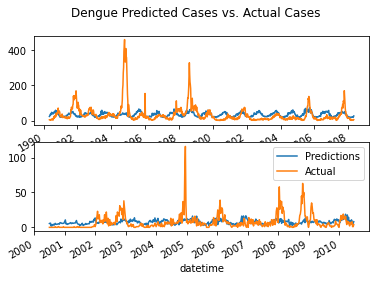

In [113]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_train['fitted'] = sj_best_model.fittedvalues
sj_train.fitted.plot(ax=axes[0], label="Predictions")
sj_train.total_cases.plot(ax=axes[0], label="Actual")

# plot iq
iq_train['fitted'] = iq_best_model.fittedvalues
iq_train.fitted.plot(ax=axes[1], label="Predictions")
iq_train.total_cases.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

## Reflecting on our performance

These graphs can actually tell us a lot about where our model is going wrong and give us some good hints about where investments will improve the model performance. For example, we see that our model in blue does track the seasonality of Dengue cases. However, the timing of the seasonality of our predictions has a mismatch with the actual results. One potential reason for this is that our features don't look far enough into the past--that is to say, we are asking to predict cases at the same time as we are measuring percipitation. Because dengue is misquito born, and the misquito lifecycle depends on water, we need to take both the life of a misquito and the time between infection and symptoms into account when modeling dengue. This is a critical avenue to explore when improving this model.

The other important error is that our predictions are relatively consistent--we miss the spikes that are large outbreaks. One reason is that we don't take into account the contagiousness of dengue. A possible way to account for this is to build a model that progressively predicts a new value while taking into account the previous prediction. By training on the dengue outbreaks and then using the predicted number of patients in the week before, we can start to model this time dependence that the current model misses.

So, we know we're not going to win this thing, but let's submit the model anyway!

In [114]:
sj_test = preprocess_data(data_path='data/Test_Data_Features.csv', city='sj')
iq_test = preprocess_data(data_path='data/Test_Data_Features.csv', city='iq')

sj_test = reindex_df(sj_test, woy_column=True)
iq_test = reindex_df(iq_test, woy_column=True)

sj_predictions = sj_best_model.predict(sj_test).astype(int)
iq_predictions = iq_best_model.predict(iq_test).astype(int)

submission = pd.read_csv("data/Submission_Format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("data/prediction.csv")

In [115]:
#iq_test.loc[iq_test.index.get_level_values('year')==2010]
iq_test['2010-01':'2010-12']

/opt/anaconda3/envs/track_ML/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  


,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_sat_precip_amt_mm,reanalysis_precip_amt_kg_per_m2,station_avg_temp_c,station_min_temp_c,ndvi_se,weekofyear
datetime,,,,,,,,,,
2010-07-01,17.654286,296.118571,307.9,293.7,82.29,34.11,27.440000,21.5,0.225129,26
2010-07-08,16.320000,294.831429,307.7,292.2,25.30,9.10,27.025000,21.2,0.330700,27
2010-07-15,18.030000,296.417143,306.4,292.5,62.14,61.09,26.950000,21.6,0.212629,28
2010-07-22,15.394286,293.638571,306.4,289.3,47.80,19.60,26.900000,14.2,0.122057,29
2010-07-29,15.468571,293.892857,308.1,290.5,56.30,18.93,27.050000,16.9,0.250086,30
2010-08-05,16.624286,295.065714,309.7,293.4,16.95,32.92,27.700000,20.0,0.332357,31
2010-08-12,13.990000,292.085714,309.3,292.2,9.88,10.50,26.433333,18.5,0.356600,32
2010-08-19,16.375714,294.812857,309.2,293.2,15.76,20.30,27.275000,21.0,0.273086,33
2010-08-26,14.484286,292.691429,311.1,292.3,7.82,14.21,27.400000,20.0,0.326700,34


![](https://community.drivendata.org/uploads/default/original/1X/7af03e4997e8487057a77f9022691b9e9cb525f7.png)

Alright, it's a start! To build your own model you can grab this notebook [from our benchmarks repo](https://github.com/drivendata/benchmarks).

Good luck, and enjoy!

<a id='window_generator'></a>

## Window Generator

Window generator class to create time windows, so that we can use previous time steps into the prediction.

In [116]:
import keras
import tensorflow as tf

In [117]:
## from https://www.tensorflow.org/tutorials/structured_data/time_series
class WindowGenerator():
  def __init__(self, input_width, label_width, 
               train_df, val_df, 
               test_df=None, shift=1,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [118]:
## Given a list of consecutive features, convert them to a window of inputs and a window of labels.
## Assume that the last column is labels, so remove it from inputs
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window



In [119]:
def plot_example(self, model=None, plot_col='past_week_cases', max_subplots=3, figsize=(12, 8)):
    inputs, labels = self.example
    plt.figure(figsize=figsize)
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

        plt.xlabel('Time [h]')

WindowGenerator.plot_example = plot_example


In [120]:
## Plot a sequence of values, along with labels and predictions.
## Unlike the previous function, this plots the time window that is passed,
## not just the time window that corresponds to each input.
def plot_sequence(self, df, # the df that will be plotted -- pass only the range that should be plotted
                  model=None, plot_col='past_week_cases', figsize=(12,8), vocal=0):
    
    window_tensor = tf.stack(
        [np.array(df[i:i+self.total_window_size]) for i in range(0,len(df)-self.total_window_size, self.label_width)]
    )
    inputs,labels = self.split_window(window_tensor)
    
    plt.figure(figsize=figsize)
    plot_col_index = self.column_indices[plot_col]

    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(range(len(df)), df[plot_col],
             label='Inputs', marker='.', zorder=-10)

    '''
    if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
        label_col_index = plot_col_index
    '''
    flattened_labels=labels.numpy().flatten()
    plt.scatter([x+self.input_width for x in range(len(flattened_labels))], 
                flattened_labels,
                edgecolors='k', label='Labels', c='#2ca02c', s=64)

    if model is not None:
        predictions = model(inputs)
        for i_pred, prediction in enumerate(predictions.numpy()):
            plt.scatter([i_pred*self.label_width+self.input_width+x for x in range(self.label_width)], prediction,
                        marker='X', edgecolors='k', #label='Predictions',
                        c='#ff7f0e', s=64)
        plt.scatter([self.input_width], predictions[0][0],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)
                
    plt.legend()

    plt.xlabel('Week #')

WindowGenerator.plot_sequence = plot_sequence

Finally, the make_dataset method will take a time series DataFrame and convert it to a tf.data.Dataset of (input_window, label_window) pairs using the tf.keras.utils.timeseries_dataset_from_array function:



In [121]:
def make_dataset(self, data, training=True):
    data = np.array(data, dtype=np.float32)
    if training: seq_stride=1 
    else: seq_stride=self.label_width
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset


The WindowGenerator object holds training, validation, and test data.

Add properties for accessing them as tf.data.Datasets using the make_dataset method you defined earlier. Also, add a standard example batch for easy access and plotting:



In [122]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example


### Prepare data

First lets normalize the data:

In [419]:
df_melt = sj_train_features.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_melt)
_ = ax.set_xticklabels(sj_train_features.keys(), rotation=80)

TypeError: Neither the `x` nor `y` variable appears to be numeric.

<Figure size 864x432 with 0 Axes>

Next lets select only the features that will be input:

In [328]:
sj_train_features.columns

Index(['week_start_date', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
       'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'weekofyear', 'total_cases'],
      dtype='object')

In [127]:
np.isnan(sj_train_features.past_week_cases.to_numpy()[0])

False

Finally we process the df's, to select only the relevant columns:

In [330]:
sj_train=process_df(sj_train_features, return_woy=True)
iq_train=process_df(iq_train_features, return_woy=True)

sj_labels=process_df(sj_train_labels, return_woy=False)
iq_labels=process_df(iq_train_labels, return_woy=False)

/opt/anaconda3/envs/track_ML/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [485]:
## Split the training datasets to allow for validation

column_indices = {name: i for i, name in enumerate(sj_train.columns)}
n_weeks = len(sj_train)
sj_train_train = sj_train[0:int(n_weeks*0.8)]
sj_train_val = sj_train[int(n_weeks*0.8):]

n_weeks = len(iq_train)
iq_train_train = iq_train[0:int(n_weeks*0.8)]
iq_train_val = iq_train[int(n_weeks*0.8):]



Example window:


In [486]:
'''
This is a bit hacky:
We target the "past_week_cases" label for the next week,
since we want the past week's cases to be part of the input.
'''
w1_sj = WindowGenerator(input_width=5, label_width=1, 
                        shift=1, 
                        train_df=sj_train_train, val_df=sj_train_val,
                        label_columns=['past_week_cases'])
w1_iq = WindowGenerator(input_width=5, label_width=1, 
                        shift=1, 
                        train_df=iq_train_train, val_df=iq_train_val,
                        label_columns=['past_week_cases'])
w1_sj


Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['past_week_cases']

In [487]:
w1_sj.column_indices

{'reanalysis_specific_humidity_g_per_kg': 0,
 'reanalysis_dew_point_temp_k': 1,
 'reanalysis_max_air_temp_k': 2,
 'reanalysis_sat_precip_amt_mm': 3,
 'reanalysis_relative_humidity_percent': 4,
 'reanalysis_tdtr_k': 5,
 'ndvi_ne': 6,
 'weekofyear': 7,
 'past_week_cases': 8}

In [488]:
## Create example input window as np.array of shape [batch, time, features].
## Stack 3 example batches together:
example_window_sj = tf.stack([np.array(sj_train_train[50:50+w1_sj.total_window_size]),
                              np.array(sj_train_train[150:150+w1_sj.total_window_size]),
                              np.array(sj_train_train[250:250+w1_sj.total_window_size])])

example_window_sj.shape

TensorShape([3, 6, 9])

In [489]:
example_inputs,example_labels=w1_sj.split_window(example_window_sj)
print('Inputs ::\n', example_inputs)
print('Labels ::\n', example_labels)

Inputs ::
 tf.Tensor(
[[[-1.80633597e+00 -1.87237282e+00 -1.98487909e+00  2.06678236e-01
   -1.53909770e+00 -1.00619364e+00  1.42078148e-01 -7.03530295e-01
   -3.71196704e-01]
  [-6.98932615e-01 -6.88526624e-01 -1.42884988e+00 -5.91389980e-02
   -3.57099402e-02 -4.33495523e-01  1.21567964e+00 -6.36527410e-01
   -2.15861563e-01]
  [-1.52552612e-01 -8.88689417e-02 -3.16791451e-01 -7.93108610e-01
    2.33610154e-01  5.68726175e-01  1.41596312e+00 -5.69524525e-01
   -3.51779812e-01]
  [-2.34921456e-01 -1.88963547e-01 -3.96224196e-01  5.29680728e-04
    2.87136996e-01 -2.04416278e-01  5.14769166e-01 -5.02521640e-01
   -3.32362919e-01]
  [-3.70372446e-01 -3.12716877e-01 -1.03168615e+00 -6.99792180e-01
    4.42238396e-01 -3.26068442e-02  4.04557036e-01 -4.35518754e-01
   -4.29447382e-01]]

 [[-8.66415933e-01 -8.25929219e-01 -1.58771537e+00 -7.93108610e-01
    6.57188706e-01 -7.48479486e-01  5.48122837e-01 -9.04538951e-01
   -5.07114953e-01]
  [-8.90211377e-01 -8.64147159e-01 -1.03168615e+00 -

In [490]:
example_inputs[0][4]

<tf.Tensor: shape=(9,), dtype=float64, numpy=
array([-0.37037245, -0.31271688, -1.03168615, -0.69979218,  0.4422384 ,
       -0.03260684,  0.40455704, -0.43551875, -0.42944738])>

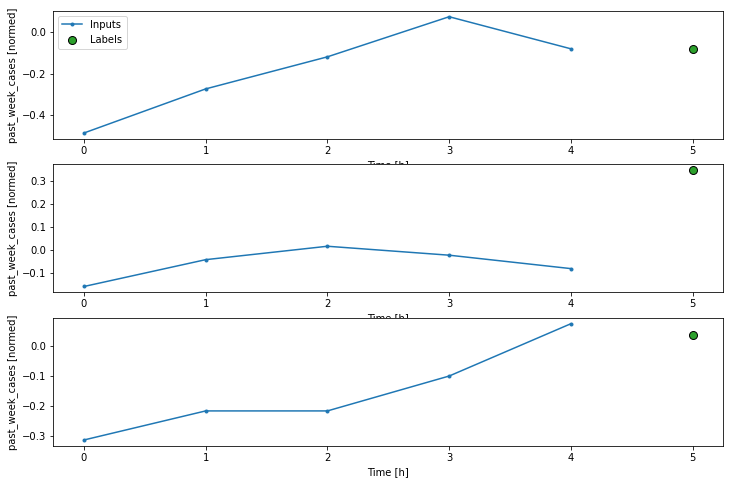

In [491]:
w1_sj.plot_example()

Now, the WindowGenerator object gives you access to the tf.data.Dataset objects, so you can easily iterate over the data.

The Dataset.element_spec property tells you the structure, data types, and shapes of the dataset elements.



In [492]:
w1_sj.train.element_spec

(TensorSpec(shape=(None, 5, 9), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a Dataset yields concrete batches:

In [493]:
for example_inputs, example_labels in w1_sj.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 5, 9)
Labels shape (batch, time, features): (32, 1, 1)


<a id='linear'></a>

## Linear model

The simplest trainable model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step.

A tf.keras.layers.Dense layer with no activation set is a linear model. The layer only transforms the last axis of the data from (batch, time, inputs) to (batch, time, units); it is applied independently to every item across the batch and time axes.



In [494]:
linear_sj = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

linear_iq = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

It takes only one time step as input, and gives the prediction for the same week. But note that same-week input also includes the total cases from the previous week.

In [495]:
same_week_window_sj = WindowGenerator(input_width=1, label_width=1, 
                                      shift=1,
                                      train_df=sj_train_train, val_df=sj_train_val,
                                      label_columns=['past_week_cases'])
same_week_window_iq = WindowGenerator(input_width=1, label_width=1, 
                                      shift=1,
                                      train_df=iq_train_train, val_df=iq_train_val,
                                      label_columns=['past_week_cases'])

same_week_window_sj

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['past_week_cases']

In [496]:
same_week_window_sj.label_columns

['past_week_cases']

In [497]:
same_week_window_sj.train.element_spec

(TensorSpec(shape=(None, 1, 9), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [498]:
for example_inputs, example_labels in same_week_window_sj.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 1, 9)
Labels shape (batch, time, features): (32, 1, 1)


Since we're creating at least 2 models, lets compare their performance:

In [499]:
val_performance = {}
val_performance['sj']={}
val_performance['iq']={}

In [500]:
MAX_EPOCHS = 1000

def compile_and_fit(model, window, patience=10):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      restore_best_weights=True)

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history


In [501]:
## Compile and fit the linear model on the appropriate single-week window

history = compile_and_fit(linear_sj, same_week_window_sj, patience=20)
val_performance['sj']['Linear'] = linear_sj.evaluate(same_week_window_sj.val)

history = compile_and_fit(linear_iq, same_week_window_iq, patience=20)
val_performance['iq']['Linear'] = linear_iq.evaluate(same_week_window_iq.val)



Epoch 1/1000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/24 [>.............................] - ETA: 7s - loss: 1.3682 - mean_absolute_error: 0.9101WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8f867485f0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOS

24/24 [==============================] - 0s 4ms/step - loss: 0.1027 - mean_absolute_error: 0.2156 - val_loss: 0.0854 - val_mean_absolute_error: 0.2158
Epoch 40/1000
24/24 [==============================] - 0s 4ms/step - loss: 0.0995 - mean_absolute_error: 0.2108 - val_loss: 0.0811 - val_mean_absolute_error: 0.2093
Epoch 41/1000
24/24 [==============================] - 0s 4ms/step - loss: 0.0966 - mean_absolute_error: 0.2063 - val_loss: 0.0772 - val_mean_absolute_error: 0.2034
Epoch 42/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.0937 - mean_absolute_error: 0.2020 - val_loss: 0.0734 - val_mean_absolute_error: 0.1967
Epoch 43/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.0915 - mean_absolute_error: 0.1979 - val_loss: 0.0700 - val_mean_absolute_error: 0.1910
Epoch 44/1000
24/24 [==============================] - 0s 4ms/step - loss: 0.0894 - mean_absolute_error: 0.1941 - val_loss: 0.0666 - val_mean_absolute_error: 0.1847
Epoch 45/1000
24/24 [===

Epoch 89/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.0731 - mean_absolute_error: 0.1603 - val_loss: 0.0484 - val_mean_absolute_error: 0.1402
Epoch 90/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.0732 - mean_absolute_error: 0.1606 - val_loss: 0.0485 - val_mean_absolute_error: 0.1406
Epoch 91/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.0732 - mean_absolute_error: 0.1605 - val_loss: 0.0485 - val_mean_absolute_error: 0.1404
Epoch 92/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.0730 - mean_absolute_error: 0.1602 - val_loss: 0.0482 - val_mean_absolute_error: 0.1399
Epoch 93/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.0731 - mean_absolute_error: 0.1605 - val_loss: 0.0485 - val_mean_absolute_error: 0.1409
Epoch 94/1000
24/24 [==============================] - 0s 3ms/step - loss: 0.0731 - mean_absolute_error: 0.1603 - val_loss: 0.0484 - val_mean_absolute_error: 0.1403
Epoch 95/1

13/13 [==============================] - 0s 6ms/step - loss: 0.7722 - mean_absolute_error: 0.5888 - val_loss: 0.7573 - val_mean_absolute_error: 0.6234
Epoch 21/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.7557 - mean_absolute_error: 0.5800 - val_loss: 0.7442 - val_mean_absolute_error: 0.6156
Epoch 22/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.7427 - mean_absolute_error: 0.5726 - val_loss: 0.7283 - val_mean_absolute_error: 0.6070
Epoch 23/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.7298 - mean_absolute_error: 0.5653 - val_loss: 0.7143 - val_mean_absolute_error: 0.5987
Epoch 24/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.7175 - mean_absolute_error: 0.5584 - val_loss: 0.7002 - val_mean_absolute_error: 0.5909
Epoch 25/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.7054 - mean_absolute_error: 0.5514 - val_loss: 0.6889 - val_mean_absolute_error: 0.5840
Epoch 26/1000
13/13 [===

Epoch 70/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4968 - mean_absolute_error: 0.4043 - val_loss: 0.4258 - val_mean_absolute_error: 0.4084
Epoch 71/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.4956 - mean_absolute_error: 0.4035 - val_loss: 0.4239 - val_mean_absolute_error: 0.4069
Epoch 72/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.4943 - mean_absolute_error: 0.4022 - val_loss: 0.4225 - val_mean_absolute_error: 0.4057
Epoch 73/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.4937 - mean_absolute_error: 0.4012 - val_loss: 0.4216 - val_mean_absolute_error: 0.4040
Epoch 74/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.4918 - mean_absolute_error: 0.4001 - val_loss: 0.4198 - val_mean_absolute_error: 0.4032
Epoch 75/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.4909 - mean_absolute_error: 0.3993 - val_loss: 0.4179 - val_mean_absolute_error: 0.4021
Epoch 76/1

13/13 [==============================] - 0s 5ms/step - loss: 0.4699 - mean_absolute_error: 0.3816 - val_loss: 0.3863 - val_mean_absolute_error: 0.3793
Epoch 120/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4696 - mean_absolute_error: 0.3813 - val_loss: 0.3863 - val_mean_absolute_error: 0.3791
Epoch 121/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4697 - mean_absolute_error: 0.3814 - val_loss: 0.3859 - val_mean_absolute_error: 0.3782
Epoch 122/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.4690 - mean_absolute_error: 0.3809 - val_loss: 0.3853 - val_mean_absolute_error: 0.3782
Epoch 123/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4691 - mean_absolute_error: 0.3808 - val_loss: 0.3854 - val_mean_absolute_error: 0.3785
Epoch 124/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4687 - mean_absolute_error: 0.3807 - val_loss: 0.3845 - val_mean_absolute_error: 0.3781
Epoch 125/1000
13/1

13/13 [==============================] - 0s 6ms/step - loss: 0.4634 - mean_absolute_error: 0.3757 - val_loss: 0.3723 - val_mean_absolute_error: 0.3695
Epoch 169/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4631 - mean_absolute_error: 0.3756 - val_loss: 0.3715 - val_mean_absolute_error: 0.3689
Epoch 170/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.4636 - mean_absolute_error: 0.3755 - val_loss: 0.3721 - val_mean_absolute_error: 0.3691
Epoch 171/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4630 - mean_absolute_error: 0.3749 - val_loss: 0.3718 - val_mean_absolute_error: 0.3687
Epoch 172/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.4628 - mean_absolute_error: 0.3750 - val_loss: 0.3715 - val_mean_absolute_error: 0.3687
Epoch 173/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.4627 - mean_absolute_error: 0.3753 - val_loss: 0.3710 - val_mean_absolute_error: 0.3686
Epoch 174/1000
13/1

13/13 [==============================] - 0s 6ms/step - loss: 0.4607 - mean_absolute_error: 0.3731 - val_loss: 0.3644 - val_mean_absolute_error: 0.3634
Epoch 218/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4612 - mean_absolute_error: 0.3734 - val_loss: 0.3648 - val_mean_absolute_error: 0.3632
Epoch 219/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4609 - mean_absolute_error: 0.3734 - val_loss: 0.3642 - val_mean_absolute_error: 0.3637
Epoch 220/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4612 - mean_absolute_error: 0.3733 - val_loss: 0.3634 - val_mean_absolute_error: 0.3638
Epoch 221/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4614 - mean_absolute_error: 0.3735 - val_loss: 0.3641 - val_mean_absolute_error: 0.3629
Epoch 222/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.4607 - mean_absolute_error: 0.3733 - val_loss: 0.3641 - val_mean_absolute_error: 0.3630
Epoch 223/1000
13/1

13/13 [==============================] - 0s 6ms/step - loss: 0.4599 - mean_absolute_error: 0.3719 - val_loss: 0.3605 - val_mean_absolute_error: 0.3614
Epoch 267/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4602 - mean_absolute_error: 0.3725 - val_loss: 0.3607 - val_mean_absolute_error: 0.3611
Epoch 268/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.4600 - mean_absolute_error: 0.3727 - val_loss: 0.3605 - val_mean_absolute_error: 0.3606
Epoch 269/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4603 - mean_absolute_error: 0.3725 - val_loss: 0.3608 - val_mean_absolute_error: 0.3602
Epoch 270/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4598 - mean_absolute_error: 0.3721 - val_loss: 0.3603 - val_mean_absolute_error: 0.3606
Epoch 271/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4603 - mean_absolute_error: 0.3725 - val_loss: 0.3607 - val_mean_absolute_error: 0.3603
Epoch 272/1000
13/1

13/13 [==============================] - 0s 6ms/step - loss: 0.4598 - mean_absolute_error: 0.3723 - val_loss: 0.3574 - val_mean_absolute_error: 0.3602
Epoch 316/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4600 - mean_absolute_error: 0.3720 - val_loss: 0.3573 - val_mean_absolute_error: 0.3607
Epoch 317/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4602 - mean_absolute_error: 0.3718 - val_loss: 0.3581 - val_mean_absolute_error: 0.3598
Epoch 318/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4596 - mean_absolute_error: 0.3715 - val_loss: 0.3578 - val_mean_absolute_error: 0.3601
Epoch 319/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4596 - mean_absolute_error: 0.3717 - val_loss: 0.3577 - val_mean_absolute_error: 0.3599
Epoch 320/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4598 - mean_absolute_error: 0.3720 - val_loss: 0.3578 - val_mean_absolute_error: 0.3594
Epoch 321/1000
13/1

13/13 [==============================] - 0s 6ms/step - loss: 0.4597 - mean_absolute_error: 0.3719 - val_loss: 0.3561 - val_mean_absolute_error: 0.3588
Epoch 365/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4598 - mean_absolute_error: 0.3721 - val_loss: 0.3562 - val_mean_absolute_error: 0.3595
Epoch 366/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4598 - mean_absolute_error: 0.3720 - val_loss: 0.3564 - val_mean_absolute_error: 0.3595
Epoch 367/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4595 - mean_absolute_error: 0.3722 - val_loss: 0.3561 - val_mean_absolute_error: 0.3596
Epoch 368/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4598 - mean_absolute_error: 0.3722 - val_loss: 0.3564 - val_mean_absolute_error: 0.3598
Epoch 369/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.4596 - mean_absolute_error: 0.3717 - val_loss: 0.3561 - val_mean_absolute_error: 0.3600
Epoch 370/1000
13/1

13/13 [==============================] - 0s 6ms/step - loss: 0.4598 - mean_absolute_error: 0.3718 - val_loss: 0.3557 - val_mean_absolute_error: 0.3589
Epoch 414/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4596 - mean_absolute_error: 0.3716 - val_loss: 0.3557 - val_mean_absolute_error: 0.3595
Epoch 415/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4598 - mean_absolute_error: 0.3719 - val_loss: 0.3551 - val_mean_absolute_error: 0.3595
Epoch 416/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4597 - mean_absolute_error: 0.3714 - val_loss: 0.3552 - val_mean_absolute_error: 0.3588
Epoch 417/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.4599 - mean_absolute_error: 0.3716 - val_loss: 0.3556 - val_mean_absolute_error: 0.3588
Epoch 418/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4597 - mean_absolute_error: 0.3718 - val_loss: 0.3555 - val_mean_absolute_error: 0.3586
Epoch 419/1000
13/1

In [505]:
print('Linear validation performance (loss, MAE) :: ')
for city in ['sj','iq']:
    print(f'{city} : ', val_performance[city]['Linear'])

Linear validation performance (loss, MAE) :: 
sj :  [0.04780535399913788, 0.13777092099189758]
iq :  [0.3550856113433838, 0.35945093631744385]


With 9 features ::  

Linear validation performance (loss, MAE) ::   
sj :  [0.04780535399913788, 0.13777092099189758]  
iq :  [0.3550856113433838, 0.35945093631744385]



Also create a validation window for plotting

In [506]:
val_window_sj = WindowGenerator(
    input_width=len(sj_train_val), label_width=len(sj_train_val), 
    train_df=sj_train_train, val_df=sj_train_val, 
    label_columns=['past_week_cases'])
val_window_iq = WindowGenerator(
    input_width=len(iq_train_val), label_width=len(iq_train_val), 
    train_df=iq_train_train, val_df=iq_train_val, 
    label_columns=['past_week_cases'])

val_window_sj


Total window size: 187
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185]
Label indices: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47 

In [507]:
print('Input shape:', val_window_sj.example[0].shape)
print('Output shape:', linear_sj(val_window_sj.example[0]).shape)


Input shape: (32, 186, 9)
Output shape: (32, 186, 1)


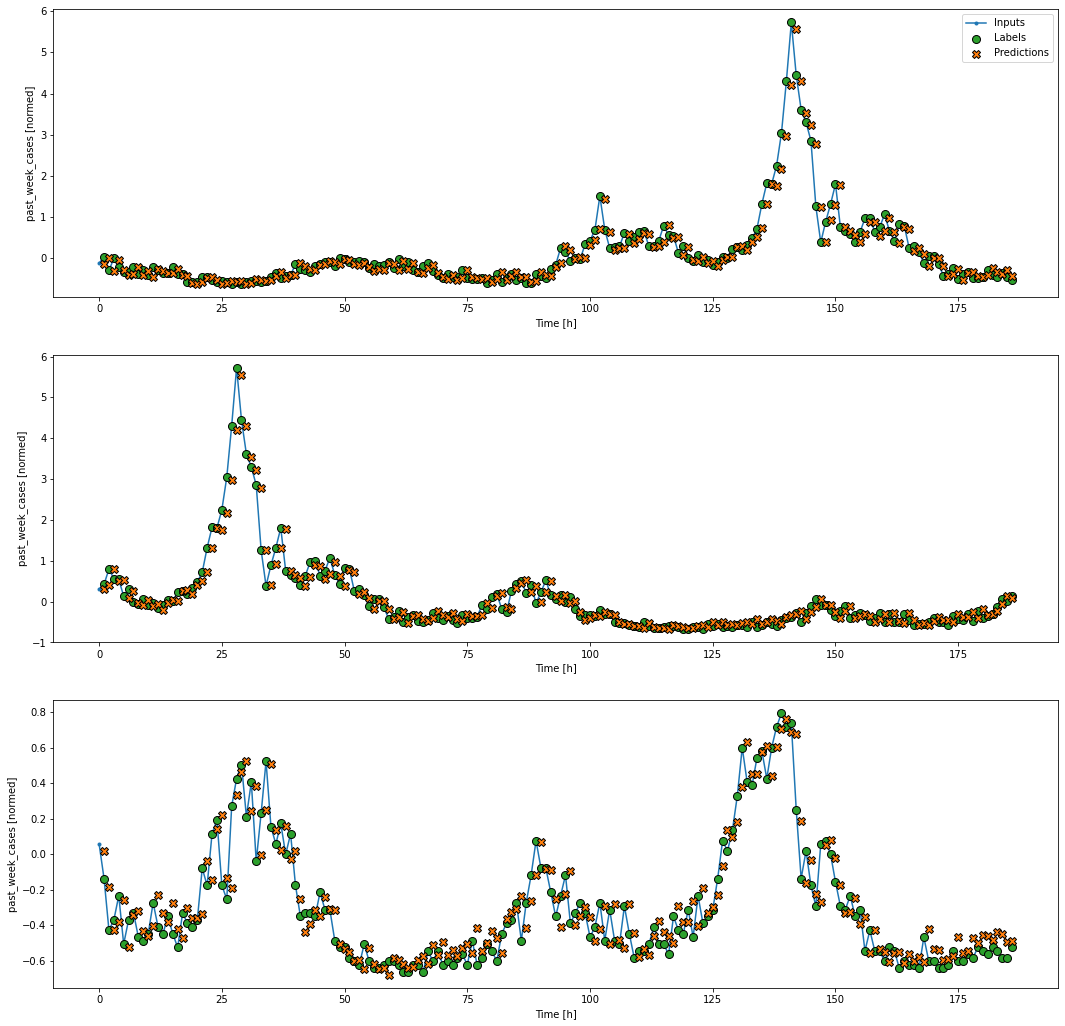

In [508]:
val_window_sj.plot_example(model=linear_sj, figsize=(18,18))


The linear model benefits significantly from having the past week's cases at its input.

<a id='dense'></a>

## Dense model

Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the linear model, except it stacks several a few Dense layers between the input and the output:

In [509]:
dense_sj = tf.keras.Sequential([
    tf.keras.layers.Dense(units=2000, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=1)
])
dense_iq = tf.keras.Sequential([
    tf.keras.layers.Dense(units=2000, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense_sj, same_week_window_sj, patience=20)
val_performance['sj']['Dense'] = dense_sj.evaluate(same_week_window_sj.val)
history = compile_and_fit(dense_iq, same_week_window_iq, patience=20)
val_performance['iq']['Dense'] = dense_iq.evaluate(same_week_window_iq.val)

Epoch 1/1000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
20/24 [========================>.....] - ETA: 0s - loss: 0.2509 - mean_absolute_error: 0.2799 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8f85fbf5f0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBO

24/24 [==============================] - 0s 5ms/step - loss: 0.0297 - mean_absolute_error: 0.1165 - val_loss: 0.0585 - val_mean_absolute_error: 0.1520
Epoch 40/1000
24/24 [==============================] - 0s 5ms/step - loss: 0.0304 - mean_absolute_error: 0.1191 - val_loss: 0.0643 - val_mean_absolute_error: 0.1719
Epoch 41/1000
24/24 [==============================] - 0s 5ms/step - loss: 0.0383 - mean_absolute_error: 0.1255 - val_loss: 0.0652 - val_mean_absolute_error: 0.1716
Epoch 42/1000
24/24 [==============================] - 0s 5ms/step - loss: 0.0730 - mean_absolute_error: 0.1644 - val_loss: 0.0755 - val_mean_absolute_error: 0.1705
Epoch 43/1000
24/24 [==============================] - 0s 5ms/step - loss: 0.0442 - mean_absolute_error: 0.1365 - val_loss: 0.0677 - val_mean_absolute_error: 0.1746
Epoch 44/1000
24/24 [==============================] - 0s 5ms/step - loss: 0.0375 - mean_absolute_error: 0.1262 - val_loss: 0.0627 - val_mean_absolute_error: 0.1498
Epoch 45/1000
24/24 [===

In [510]:
print('Dense validation performance (loss, MAE) :: ')
for city in ['sj','iq']:
    print(f'{city} : ', val_performance[city]['Dense'])

Dense validation performance (loss, MAE) :: 
sj :  [0.04880022257566452, 0.1389329582452774]
iq :  [0.40246307849884033, 0.3836075961589813]


With 9 features ::  

Dense validation performance (loss, MAE) ::   
sj :  [0.04880022257566452, 0.1389329582452774]  
iq :  [0.40246307849884033, 0.3836075961589813]


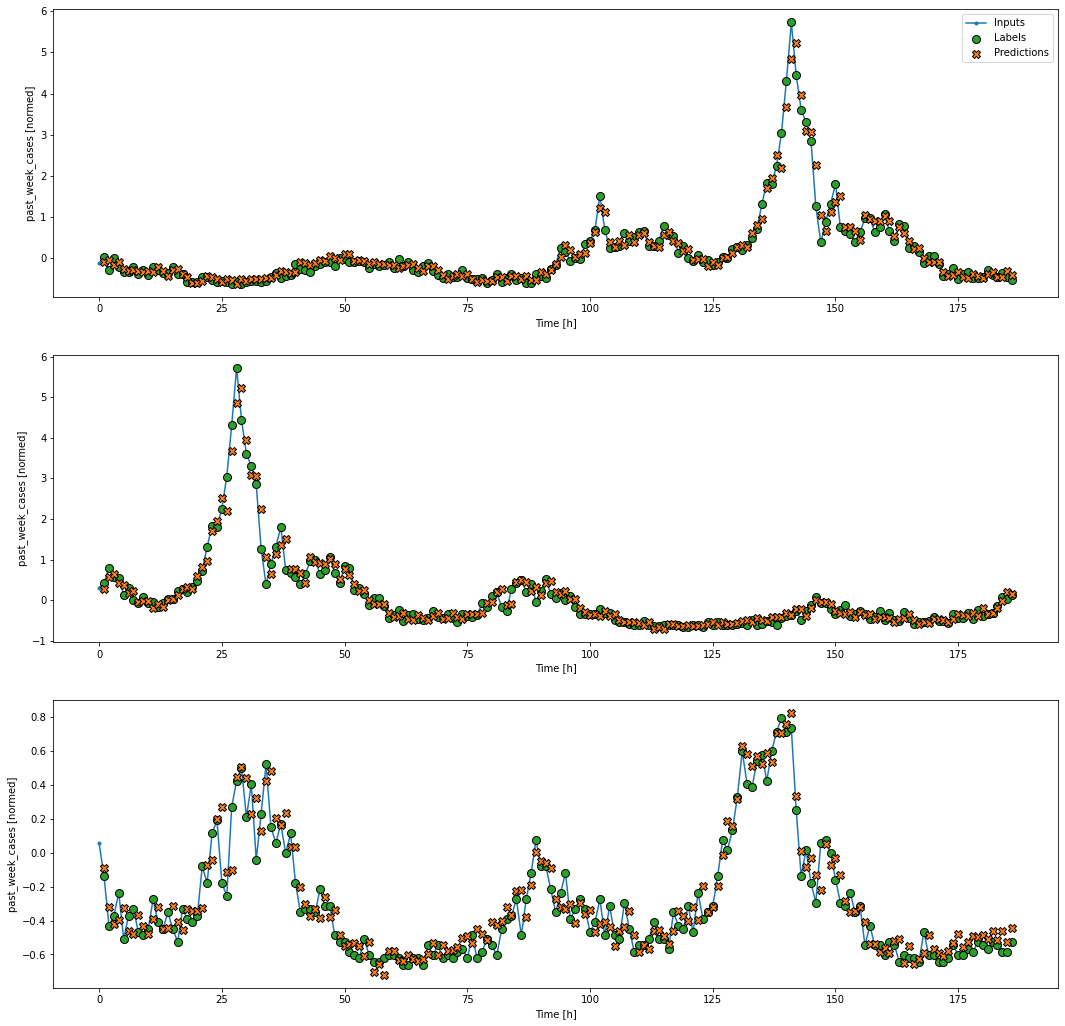

In [511]:
val_window_sj.plot_example(model=dense_sj, figsize=(18,18))

The Dense model seems a little more clever than the linear one, it is able to take into account more complicated connections between the input features and the target in every week.

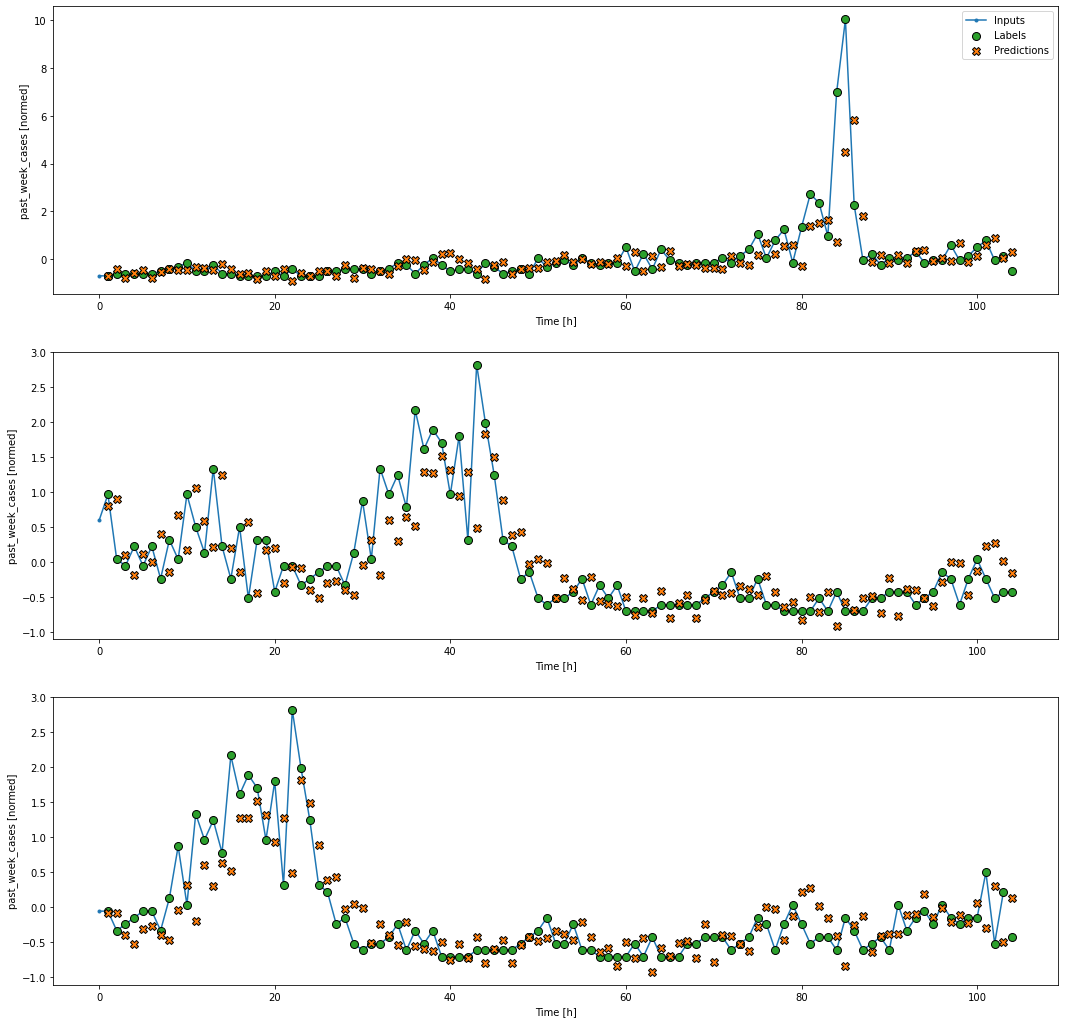

In [512]:
val_window_iq.plot_example(model=dense_iq, figsize=(18,18))

<a id='LSTM'></a>

## LSTM model

Now let's try with a Deep Learning model based on LSTM layers.

The shape of the input to the LSTM model will be [samples, timesteps, features].  


In [513]:
lstm_model_sj = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    #tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(100, return_sequences=False),
    #tf.keras.layers.TimeDistributed(
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

lstm_model_iq = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    #tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(100, return_sequences=False),
    #tf.keras.layers.TimeDistributed(
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [514]:
lstm_window_sj = WindowGenerator(input_width=20, label_width=1, 
                                 shift=1, 
                                 train_df=sj_train_train, val_df=sj_train_val,
                                 label_columns=['past_week_cases'])
lstm_window_iq = WindowGenerator(input_width=20, label_width=1, 
                                 shift=1, 
                                 train_df=iq_train_train, val_df=iq_train_val,
                                 label_columns=['past_week_cases'])
'''
This is a bit hacky:
We target the "past_week_cases" label for the next week,
since we want the past week's cases to be part of the input.
'''
lstm_window_sj



Total window size: 21
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Label indices: [20]
Label column name(s): ['past_week_cases']

In [515]:
lstm_window_sj.train.element_spec

(TensorSpec(shape=(None, 20, 9), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [516]:
history = compile_and_fit(lstm_model_sj, lstm_window_sj, patience=50)
val_performance['sj']['LSTM'] = lstm_model_sj.evaluate(lstm_window_sj.val)

history = compile_and_fit(lstm_model_iq, lstm_window_iq, patience=50)
val_performance['iq']['LSTM'] = lstm_model_iq.evaluate(lstm_window_iq.val)

Epoch 1/1000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
19/23 [=======================>......] - ETA: 0s - loss: 0.7228 - mean_absolute_error: 0.3756WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8f8595b9e0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOS

Epoch 39/1000
23/23 [==============================] - 0s 15ms/step - loss: 0.0230 - mean_absolute_error: 0.1045 - val_loss: 0.1556 - val_mean_absolute_error: 0.2248
Epoch 40/1000
23/23 [==============================] - 0s 19ms/step - loss: 0.0204 - mean_absolute_error: 0.0983 - val_loss: 0.1612 - val_mean_absolute_error: 0.2357
Epoch 41/1000
23/23 [==============================] - 0s 15ms/step - loss: 0.0207 - mean_absolute_error: 0.1027 - val_loss: 0.1293 - val_mean_absolute_error: 0.2084
Epoch 42/1000
23/23 [==============================] - 0s 16ms/step - loss: 0.0215 - mean_absolute_error: 0.1028 - val_loss: 0.1745 - val_mean_absolute_error: 0.2309
Epoch 43/1000
23/23 [==============================] - 0s 17ms/step - loss: 0.0197 - mean_absolute_error: 0.0965 - val_loss: 0.1683 - val_mean_absolute_error: 0.2354
Epoch 44/1000
23/23 [==============================] - 0s 15ms/step - loss: 0.0209 - mean_absolute_error: 0.0984 - val_loss: 0.1678 - val_mean_absolute_error: 0.2389
Epoc

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
13/13 [==============================] - 2s 52ms/step - loss: 0.7436 - mean_absolute_error: 0.4719 - val_loss: 0.4813 - val_mean_absolute_error: 0.5171
Epoch 2/1000
13/13 [==============================] - 0s 20ms/step - loss: 0.5616 - mean_absolute_error: 0.4013 - val_loss: 0.4055 - val_mean_absolute_error: 0.4555
Epoch 3/1000
13/13 [==============================] - 0s 18ms/step - loss: 0.4970 - mean_absolute_error: 0.3720 - val_loss: 0.3535 - val_mean_absolute_error: 0.4238
Epoch 4/1000
13/13 [==============================] - 0s 18ms/step - loss: 0.4579 - mean_absolute_error: 0.3539 - val_loss: 0.3343 - val_mean_absolute_error: 0.4094
Epoch 5/1000
13/13 [======================

Epoch 48/1000
13/13 [==============================] - 0s 19ms/step - loss: 0.0858 - mean_absolute_error: 0.1900 - val_loss: 0.6165 - val_mean_absolute_error: 0.5189
Epoch 49/1000
13/13 [==============================] - 0s 18ms/step - loss: 0.0812 - mean_absolute_error: 0.1895 - val_loss: 0.6116 - val_mean_absolute_error: 0.5085
Epoch 50/1000
13/13 [==============================] - 0s 18ms/step - loss: 0.0786 - mean_absolute_error: 0.1854 - val_loss: 0.6263 - val_mean_absolute_error: 0.5166
Epoch 51/1000
13/13 [==============================] - 0s 19ms/step - loss: 0.0683 - mean_absolute_error: 0.1741 - val_loss: 0.6422 - val_mean_absolute_error: 0.5198
Epoch 52/1000
13/13 [==============================] - 0s 18ms/step - loss: 0.0773 - mean_absolute_error: 0.1817 - val_loss: 0.6753 - val_mean_absolute_error: 0.5438
Epoch 53/1000
13/13 [==============================] - 0s 18ms/step - loss: 0.0772 - mean_absolute_error: 0.1912 - val_loss: 0.6444 - val_mean_absolute_error: 0.5223
Epoc

In [517]:
print('LSTM validation performance (loss, MAE) :: ')
for city in ['sj','iq']:
    print(f'{city} : ', val_performance[city]['LSTM'])

LSTM validation performance (loss, MAE) :: 
sj :  [0.09919413924217224, 0.1871810406446457]
iq :  [0.24140456318855286, 0.33573782444000244]


With 9 features ::  

LSTM validation performance (loss, MAE) ::   
sj :  [0.09919413924217224, 0.1871810406446457]  
iq :  [0.24140456318855286, 0.33573782444000244]

In [518]:
val_window_data = tf.stack([np.array(sj_train_val[:lstm_window_sj.total_window_size]),
                            np.array(sj_train_val[25:25+lstm_window_sj.total_window_size]),
                            np.array(sj_train_val[75:75+lstm_window_sj.total_window_size])])


In [519]:
val_inputs, val_labels = lstm_window_sj.split_window(val_window_data)

print('Shapes: (batch, time, features)')
print(f'Window shape: {val_window_data.shape}')
print(f'Inputs shape: {val_inputs.shape}')
print(f'Labels shape: {val_labels.shape}')


Shapes: (batch, time, features)
Window shape: (3, 21, 9)
Inputs shape: (3, 20, 9)
Labels shape: (3, 1, 1)


In [520]:
val_window_stacked = tf.stack(
    [np.array(sj_train_val[i:i+lstm_window_sj.total_window_size]) for i in range(len(sj_train_val)-lstm_window_sj.total_window_size)]
)
val_window_stacked.shape

TensorShape([165, 21, 9])

In [454]:
'''
val_window_stacked =[]
for i in range(len(val_df)-lstm_window.total_window_size):
    val_window_stacked += [np.array( val_df[i:i+lstm_window.total_window_size])]
val_window_stacked=np.array(val_window_stacked)
val_window_stacked.shape
'''

'\nval_window_stacked =[]\nfor i in range(len(val_df)-lstm_window.total_window_size):\n    val_window_stacked += [np.array( val_df[i:i+lstm_window.total_window_size])]\nval_window_stacked=np.array(val_window_stacked)\nval_window_stacked.shape\n'

In [521]:
val_inputs, val_labels = lstm_window_sj.split_window(val_window_stacked)
lstm_model_sj(val_inputs)

<tf.Tensor: shape=(165, 1), dtype=float32, numpy=
array([[-0.4137231 ],
       [-0.45812201],
       [-0.48249394],
       [-0.5840984 ],
       [-0.59548736],
       [-0.54800355],
       [-0.5430954 ],
       [-0.58958256],
       [-0.60731864],
       [-0.5667416 ],
       [-0.5325068 ],
       [-0.4522081 ],
       [-0.5156567 ],
       [-0.5016877 ],
       [-0.5496677 ],
       [-0.5419173 ],
       [-0.539197  ],
       [-0.4785738 ],
       [-0.44444698],
       [-0.3113915 ],
       [-0.18891588],
       [-0.08572812],
       [ 0.04000648],
       [ 0.09115972],
       [ 0.24203521],
       [ 0.48538402],
       [ 0.778489  ],
       [ 0.970055  ],
       [ 1.1191856 ],
       [ 1.2884191 ],
       [ 1.7618768 ],
       [ 1.7362372 ],
       [ 1.6012082 ],
       [ 1.38774   ],
       [ 0.8991374 ],
       [ 0.6867112 ],
       [ 0.84545946],
       [ 0.60718024],
       [ 0.50259554],
       [ 0.27511483],
       [ 0.18284525],
       [ 0.07624139],
       [ 0.01614053],
    

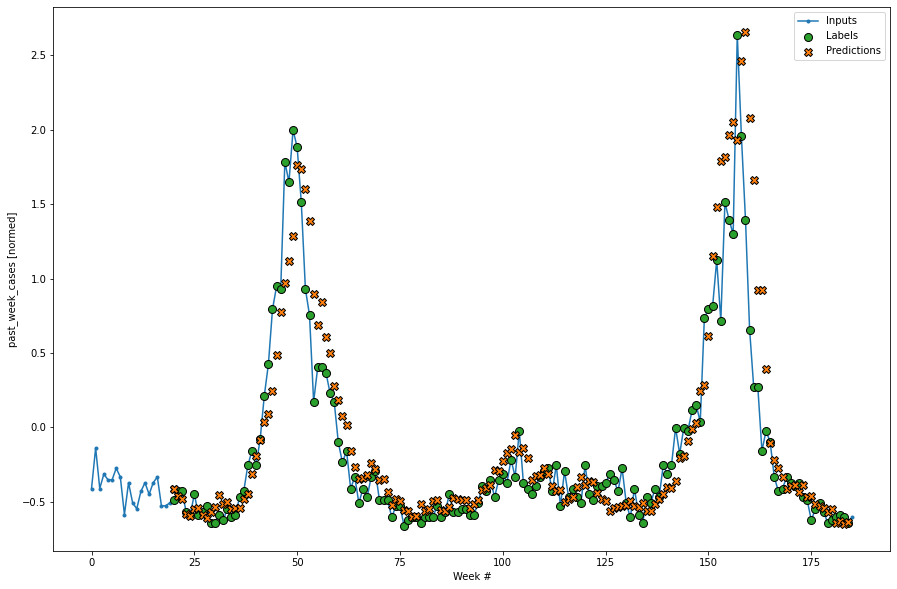

In [522]:
lstm_window_sj.plot_sequence(df=sj_train_val, model=lstm_model_sj, figsize=(15,10))

Not bad, the LSTM seems to be predicting the validation set pretty well.

* We are doing a lot better on the spikes with just 9 features. The LSTM must be learning to pay more attention to the past week's cases.

**TO DO :**
Consider studying whether stateful LSTM would work better, with not-shuffled training data.  
See eg http://philipperemy.github.io/keras-stateful-lstm/.

<a id='many_steps_future'></a>

## Predicting many steps into the future

Now we tune the LSTM to predict for many steps into the future.  
There is some noise week-to-week, so we can probably make a reasonable prediction for the entire next month in one go. This should be more stable.  

Also our final target is to predict many *months* into the future. So we should train our network to do that, rather than try to optimize for very near-term prediction.

In [523]:
## Test set size
print('SJ test width : ', len(sj_test))
print('Iq test width : ', len(iq_test))

SJ test width :  260
Iq test width :  156


Let's construct a LSTM that predicts ~4 steps into the future.  
We will later use it as the fundamental building block in an autoregressive manner.

**TO DO:**
Try different combinations of input/output widths for the fundamental unit.

In [524]:
n_prediction_weeks=4
n_input_weeks=20

In [525]:
lstm_ManyWeeks_model_sj = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    #tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(500, return_sequences=True),
    keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(100, return_sequences=False),
    #tf.keras.layers.TimeDistributed(
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dense(units=50, activation='relu'),
    tf.keras.layers.Dense(units=n_prediction_weeks)
])
lstm_ManyWeeks_model_iq = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    #tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(500, return_sequences=True),
    keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(100, return_sequences=False),
    #tf.keras.layers.TimeDistributed(
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dense(units=50, activation='relu'),
    tf.keras.layers.Dense(units=n_prediction_weeks)
])

In [526]:
lstm_ManyWeeks_window_sj = WindowGenerator(input_width=n_input_weeks, 
                                           label_width=n_prediction_weeks,
                                           shift=n_prediction_weeks, 
                                           train_df=sj_train_train, val_df=sj_train_val,
                                           label_columns=['past_week_cases'])

lstm_ManyWeeks_window_iq = WindowGenerator(input_width=n_input_weeks, 
                                           label_width=n_prediction_weeks,
                                           shift=n_prediction_weeks, 
                                           train_df=iq_train_train, val_df=iq_train_val,
                                           label_columns=['past_week_cases'])


lstm_ManyWeeks_window_sj


Total window size: 24
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Label indices: [20 21 22 23]
Label column name(s): ['past_week_cases']

In [527]:
lstm_ManyWeeks_window_sj.train.element_spec

(TensorSpec(shape=(None, 20, 9), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 4, 1), dtype=tf.float32, name=None))

In [528]:
for example_inputs, example_labels in lstm_ManyWeeks_window_sj.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')



Inputs shape (batch, time, features): (32, 20, 9)
Labels shape (batch, time, features): (32, 4, 1)


In [529]:
history = compile_and_fit(lstm_ManyWeeks_model_sj, lstm_ManyWeeks_window_sj, patience=30)

history = compile_and_fit(lstm_ManyWeeks_model_iq, lstm_ManyWeeks_window_iq, patience=30)

Epoch 1/1000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
23/23 [==============================] - ETA: 0s - loss: 0.7657 - mean_absolute_error: 0.3991WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8f85a2ddd0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOS

Epoch 39/1000
23/23 [==============================] - 3s 145ms/step - loss: 0.0270 - mean_absolute_error: 0.1084 - val_loss: 0.1641 - val_mean_absolute_error: 0.2324
Epoch 40/1000
23/23 [==============================] - 3s 133ms/step - loss: 0.0240 - mean_absolute_error: 0.1025 - val_loss: 0.1730 - val_mean_absolute_error: 0.2299
Epoch 41/1000
23/23 [==============================] - 3s 131ms/step - loss: 0.0253 - mean_absolute_error: 0.1036 - val_loss: 0.1664 - val_mean_absolute_error: 0.2313
Epoch 42/1000
23/23 [==============================] - 3s 133ms/step - loss: 0.0282 - mean_absolute_error: 0.1077 - val_loss: 0.1817 - val_mean_absolute_error: 0.2372
Epoch 1/1000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please r

13/13 [==============================] - 2s 171ms/step - loss: 0.1671 - mean_absolute_error: 0.2422 - val_loss: 0.4209 - val_mean_absolute_error: 0.3976
Epoch 35/1000
13/13 [==============================] - 2s 171ms/step - loss: 0.1409 - mean_absolute_error: 0.2294 - val_loss: 0.4512 - val_mean_absolute_error: 0.4226
Epoch 36/1000
13/13 [==============================] - 3s 202ms/step - loss: 0.1304 - mean_absolute_error: 0.2215 - val_loss: 0.4644 - val_mean_absolute_error: 0.4292
Epoch 37/1000
13/13 [==============================] - 2s 187ms/step - loss: 0.1237 - mean_absolute_error: 0.2182 - val_loss: 0.4136 - val_mean_absolute_error: 0.3994
Epoch 38/1000
13/13 [==============================] - 2s 152ms/step - loss: 0.1194 - mean_absolute_error: 0.2175 - val_loss: 0.4535 - val_mean_absolute_error: 0.4233
Epoch 39/1000
13/13 [==============================] - 2s 155ms/step - loss: 0.1093 - mean_absolute_error: 0.2084 - val_loss: 0.4441 - val_mean_absolute_error: 0.4249
Epoch 40/100

In [530]:
lstm_ManyWeeks_model_sj.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 20, 500)           1020000   
                                                                 
 dropout_3 (Dropout)         (None, 20, 500)           0         
                                                                 
 lstm_13 (LSTM)              (None, 100)               240400    
                                                                 
 dense_42 (Dense)            (None, 100)               10100     
                                                                 
 dense_43 (Dense)            (None, 50)                5050      
                                                                 
 dense_44 (Dense)            (None, 4)                 204       
                                                                 
Total params: 1,275,754
Trainable params: 1,275,754
N

In [531]:
val_performance['sj']['LSTM_mw'] = lstm_ManyWeeks_model_sj.evaluate(lstm_ManyWeeks_window_sj.val)
val_performance['iq']['LSTM_mw'] = lstm_ManyWeeks_model_iq.evaluate(lstm_ManyWeeks_window_iq.val)

print('LSTM validation performance (loss, MAE) :: ')
for city in ['sj','iq']:
    print(f'{city} : ', val_performance[city]['LSTM_mw'])



3/3 [==============================] - 0s 40ms/step - loss: 0.3486 - mean_absolute_error: 0.4083
LSTM validation performance (loss, MAE) :: 
sj :  [0.13793818652629852, 0.21325133740901947]
iq :  [0.3486480116844177, 0.4082563519477844]


With 9 features :: 
 
LSTM validation performance (loss, MAE) ::  
sj :  [0.13793818652629852, 0.21325133740901947]  
iq :  [0.3486480116844177, 0.4082563519477844]

 

In [532]:
df=sj_train_val 
window_tensor = tf.stack(
    [np.array(df[i:i+lstm_ManyWeeks_window_sj.total_window_size]) for i in range(0,len(df)-lstm_ManyWeeks_window_sj.total_window_size, 
                                                                                 lstm_ManyWeeks_window_sj.label_width)]
)
inputs,labels = lstm_ManyWeeks_window_sj.split_window(window_tensor)

print('inputs : ', inputs.shape)
print('labels : ', labels.shape)

predictions = lstm_ManyWeeks_model_sj(inputs)

print('predictions shape: ', predictions.shape)
for i_pred,pred in enumerate(predictions.numpy()):
    print(i_pred, pred)
    if i_pred>10: break
        
print('predictions[:][0] : ', predictions.numpy()[:,0])

inputs :  (41, 20, 9)
labels :  (41, 4, 1)
predictions shape:  (41, 4)
0 [-0.44032156 -0.4593144  -0.5194169  -0.5063007 ]
1 [-0.56285363 -0.61617094 -0.667548   -0.626054  ]
2 [-0.62188405 -0.6549842  -0.72610533 -0.65010816]
3 [-0.6004143 -0.6247353 -0.6845652 -0.6024318]
4 [-0.49735245 -0.48280364 -0.5179404  -0.44683188]
5 [0.13193506 0.19043848 0.19813263 0.29184088]
6 [0.6925617  0.6635112  0.64070237 0.61156833]
7 [0.7160821  0.6403304  0.6432652  0.54558766]
8 [1.2053933  1.0316876  1.0524853  0.91904217]
9 [0.32974973 0.22946191 0.2478238  0.03834888]
10 [-0.13822371 -0.2608691  -0.26373413 -0.3524167 ]
11 [-0.3041729  -0.36795974 -0.39732903 -0.3875543 ]
predictions[:][0] :  [-0.44032156 -0.56285363 -0.62188405 -0.6004143  -0.49735245  0.13193506
  0.6925617   0.7160821   1.2053933   0.32974973 -0.13822371 -0.3041729
 -0.42559078 -0.48965368 -0.5454806  -0.5931595  -0.601263   -0.56862974
 -0.45274165 -0.25848952 -0.09785521 -0.16538209 -0.33716235 -0.4605812
 -0.52177393 -0.

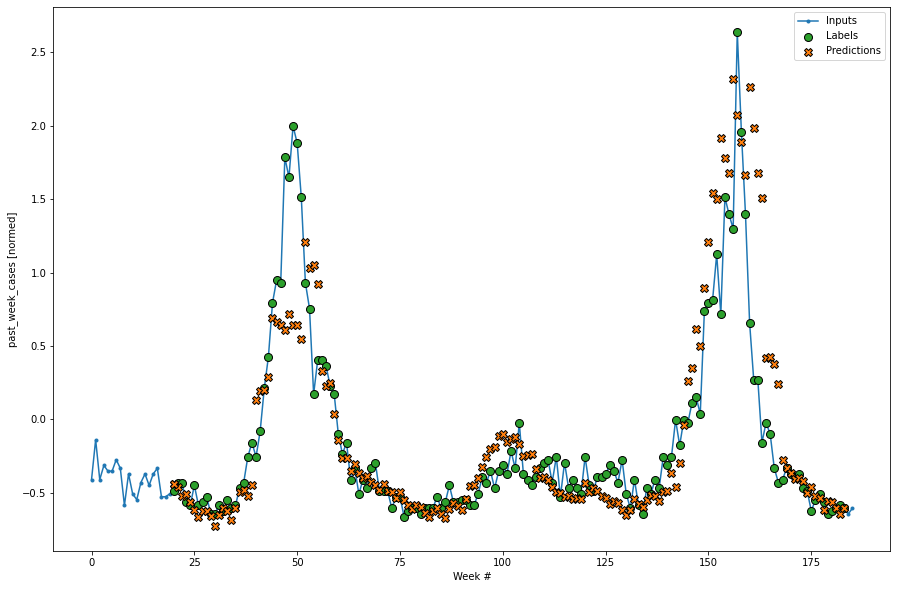

In [533]:
lstm_ManyWeeks_window_sj.plot_sequence(df=df, model=lstm_ManyWeeks_model_sj, figsize=(15,10), vocal=1)

inputs :  (20, 20, 9)
labels :  (20, 4, 1)
predictions shape:  (20, 4)
0 [2.2683036  1.6135191  1.1627342  0.86430246]
1 [1.158568   0.8592618  0.7315916  0.37878945]
2 [ 0.2506615  -0.0080494   0.08539886 -0.01021633]
3 [0.18511166 0.11716026 0.19677468 0.01276622]
4 [0.9135658  0.6032428  0.5400679  0.23975825]
5 [ 0.24240789  0.06466591  0.05315927 -0.07412478]
6 [-0.02951523 -0.10497017 -0.08714837 -0.20553793]
7 [-0.25821036 -0.38890234 -0.3809583  -0.33371454]
8 [-0.43396917 -0.52674174 -0.5052355  -0.45518404]
9 [-0.2844143  -0.29708695 -0.23208416 -0.24318099]
10 [-0.37178648 -0.3416756  -0.3651224  -0.34201235]
11 [-0.24452281 -0.26270896 -0.23430784 -0.20907915]
predictions[:][0] :  [ 2.2683036   1.158568    0.2506615   0.18511166  0.9135658   0.24240789
 -0.02951523 -0.25821036 -0.43396917 -0.2844143  -0.37178648 -0.24452281
 -0.21988606 -0.18289244 -0.03800558  0.3641784   0.45633122  0.30037466
  0.92853683  0.05356185]


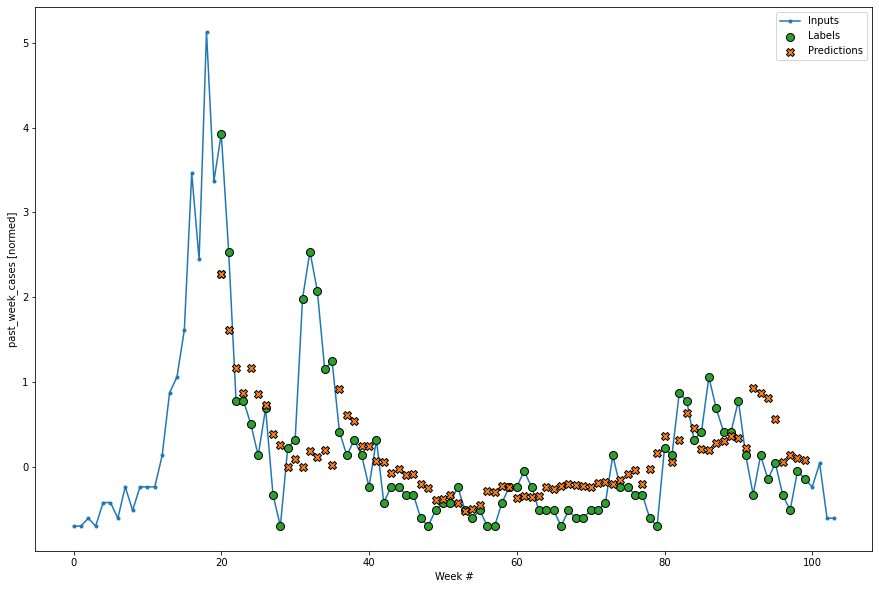

In [535]:
df=iq_train_val 
window_tensor = tf.stack(
    [np.array(df[i:i+lstm_ManyWeeks_window_iq.total_window_size]) for i in range(0,len(df)-lstm_ManyWeeks_window_iq.total_window_size, 
                                                                                 lstm_ManyWeeks_window_iq.label_width)]
)
inputs,labels = lstm_ManyWeeks_window_iq.split_window(window_tensor)

print('inputs : ', inputs.shape)
print('labels : ', labels.shape)

predictions = lstm_ManyWeeks_model_iq(inputs)

print('predictions shape: ', predictions.shape)
for i_pred,pred in enumerate(predictions.numpy()):
    print(i_pred, pred)
    if i_pred>10: break
        
print('predictions[:][0] : ', predictions.numpy()[:,0])

lstm_ManyWeeks_window_iq.plot_sequence(df=df, model=lstm_ManyWeeks_model_iq, figsize=(15,10), vocal=1)

Predicting a few steps into the future smoothens out the noise.  
We are still timid with outliers on large spikes -- which again should be expected.  
We are perhaps a little further away from truth in some cases, but that is also expected since we are predicting further into the future, so we should expect our acuracy to drop. We don't have the benefit of knowing the truth over the past month for every prediction anymore.

In [536]:
## Let's save the trained model to file
lstm_ManyWeeks_model_sj.save('saved_models/lstm_ManyWeeks_model_9feat_sj.h5')
lstm_ManyWeeks_model_iq.save('saved_models/lstm_ManyWeeks_model_9feat_iq.h5')

## To load after it is saved:
#lstm_ManyWeeks_model = tf.keras.models.load_model('saved_models/lstm_ManyWeeks_model.h5')
#lstm_ManyWeeks_model.summary()


**TO DO** : Let's iterate on the LSTM hyper-parameters to find the optimal performance.

**TO DO** : Switch the predictions back from their normalized values

<a id='autoregressive_LSTM'></a>

## Auto-regressive LSTM

The above models all predict the entire output sequence in a single step.

In some cases it is helpful for the model to decompose this prediction into individual time steps. Then, each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one.

One clear advantage to this style of model is that it can be set up to produce output with a varying length.
* And ideally we'd be able to set the custom loss function on the full output, better targeting our training. 


The feedback_predict function will still be a member of the window generator, as its characteristics are tied to those of the window/model: width of input, and with of prediction of the underlying model unit.  

However the "unit" prediction is fed back into the next input, allowing predictions over much longer periods into the future.

In [537]:
len(sj_train_val)

186

In [538]:
def feedback_predict(self, input_df, model, n_future_weeks=20, 
                     plot_col='past_week_cases', figsize=(12,8)):
    '''
    Note: The input df should contain at least self.input_width entries with known past_week_cases.
    And then followed by at least n_future_weeks with climatological data but no labels, 
    ie the past_week_cases column should be NULL.
    
    Need to have n_future_weeks % self.label_width = 0, for simplicity. 
    '''
    df_future = input_df[-n_future_weeks:]
    df_past = input_df[:-n_future_weeks]
    print('n_future_weeks : ', n_future_weeks)
    print('n_past_weeks : ', len(df_past))
    print('self.total_window_size : ', self.total_window_size)
    print('Label width : ', self.label_width)

    plot_col_index = self.column_indices[plot_col]


    ### First, warmup with the inputs that contain past cases.
    n_warmup_inputs = int( (len(df_past) - self.total_window_size) / self.label_width )
    print('warmup inputs : ', n_warmup_inputs-1)
    
    window_tensor = tf.stack(
        [np.array(df_past[-self.total_window_size-i*self.label_width:-i*self.label_width]) 
         for i in range(n_warmup_inputs,0,-1)]
    )    
    inputs = window_tensor[:, self.input_slice, :]
    inputs.set_shape([None, self.input_width, None])

    warmup_predictions=[]
    for i_warmup in range(n_warmup_inputs):
        this_input = tf.expand_dims(inputs[i_warmup],0)
        this_predictions=model(this_input)
        for prediction in this_predictions[0].numpy():
            warmup_predictions+=[prediction]
        
    print('Warmup Predictions shape : ', len(warmup_predictions))
      
    
    #### Then predict the future!
    ## Construct the inputs for the future predictions
    n_future_inputs = int( n_future_weeks / self.label_width)
    print('future inputs: ', n_future_inputs)
    window_tensor = tf.stack(
        [np.array(input_df[-self.total_window_size-i*self.label_width:-i*self.label_width]) 
         for i in range(n_future_inputs,0,-1)]
    )    
    print('future window_tensor shape : \n', window_tensor.shape)
    ## A np version of the tensor that we can modify
    window_tensor_np = window_tensor.numpy()
    #print('window_tensor_np : \n', window_tensor_np)

    inputs = window_tensor[:, self.input_slice, :]
    inputs.set_shape([None, self.input_width, None])
    
    ## Make prediction for each input, then feed the predictions to the next input
    future_predictions=[]
    for i_in in range(n_future_inputs):
        this_input = tf.expand_dims(inputs[i_in],0)
        this_predictions=model(this_input)[0].numpy()
        for i_pred, prediction in enumerate(this_predictions):
            future_predictions+=[prediction]
            if i_in>=n_future_inputs-1: continue

            ## prepare the next input
            #print('initial tensor_np time step: ', window_tensor_np[i_in+1][-self.label_width+i_pred])
            #print('cases prediction : ', prediction)
            window_tensor_np[i_in+1][-self.label_width+i_pred][plot_col_index] = prediction
            #print('modified tensor_np time step: ', window_tensor_np[i_in+1][-self.label_width+i_pred])
            window_tensor = tf.convert_to_tensor(window_tensor_np)
            inputs = window_tensor[:,self.input_slice,:]
            inputs.set_shape([None, self.input_width, None])
    
    print(f'future predictions ({len(future_predictions)}): \n', future_predictions)

    
    
    #### Next plot inputs, predictions, and labels
    plt.figure(figsize=figsize)
    plt.ylabel(f'{plot_col} [normed]')
    ## first the inputs
    plt.plot(range(len(df_past)), df_past[plot_col],
             label='Inputs', marker='.', zorder=-10)
    
    ## then the warmup predictions
    plt.scatter([len(df_past)-len(warmup_predictions)+x for x in range(len(warmup_predictions))], warmup_predictions,
                marker='X', edgecolors='k', label='Warmup Predictions',
                c='#ff7f0e', s=64)
    
    ## then the future predictions
    plt.scatter([len(df_past)+x for x in range(len(future_predictions))], future_predictions,
                marker='X', edgecolors='k', label='Future Predictions',
                c='r', s=64)

    ## finally the real predictions, if they exist
    if any([not x for x in df_future[plot_col].isnull().values]):
        ## non-Null labels exist
        plt.scatter([len(df_past)+x for x in range(len(df_future))], df_future[plot_col],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
    
    plt.legend()
    plt.xlabel('Week #')
    
    
    print('Predictions accuracy metrics : ')
    print('MAE = %.3f'% 
          sklearn.metrics.mean_absolute_error(df_future[plot_col].values, future_predictions) )
    print('MSE = %.3f'% 
          sklearn.metrics.mean_squared_error(df_future[plot_col].values, future_predictions) )


    return future_predictions

WindowGenerator.feedback_predict=feedback_predict



n_future_weeks :  20
n_past_weeks :  166
self.total_window_size :  24
Label width :  4
warmup inputs :  34
Warmup Predictions shape :  140
future inputs:  5
future window_tensor shape : 
 (5, 24, 9)
future predictions (20): 
 [1.0911888, 1.0267231, 0.92344725, 0.8399044, -0.1595471, -0.1796113, -0.16616955, -0.28868958, -0.33579257, -0.36796921, -0.4363313, -0.43017396, -0.47203654, -0.48197436, -0.5722023, -0.50573766, -0.5398626, -0.56762606, -0.6242003, -0.57635456]
Predictions accuracy metrics : 
MAE = 0.366
MSE = 0.381


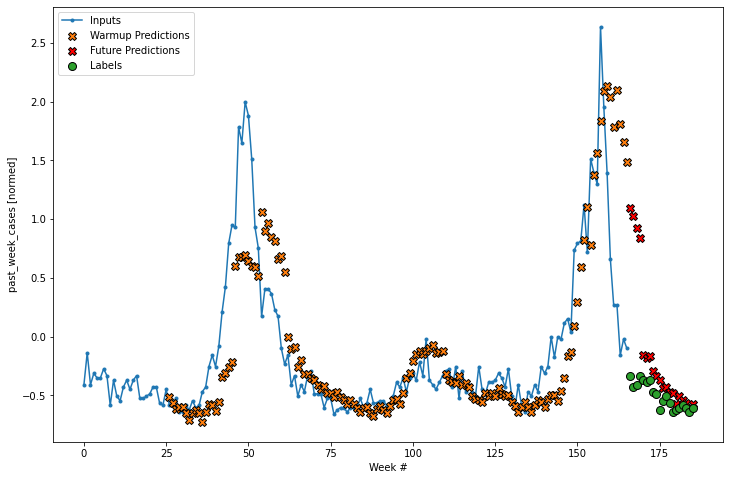

In [539]:
future_predictions_sj = lstm_ManyWeeks_window_sj.feedback_predict(sj_train_val, lstm_ManyWeeks_model_sj, n_future_weeks=20)

n_future_weeks :  20
n_past_weeks :  84
self.total_window_size :  24
Label width :  4
warmup inputs :  14
Warmup Predictions shape :  60
future inputs:  5
future window_tensor shape : 
 (5, 24, 9)
future predictions (20): 
 [0.36417845, 0.055673745, 0.31724775, 0.6312687, 0.45633128, 0.20692311, 0.19237354, 0.2777258, 0.3003747, 0.36377475, 0.33569983, 0.21844013, 0.92853665, 0.8675697, 0.8133167, 0.56158143, 0.05356185, 0.13994193, 0.10048068, 0.08235299]
Predictions accuracy metrics : 
MAE = 0.486
MSE = 0.382


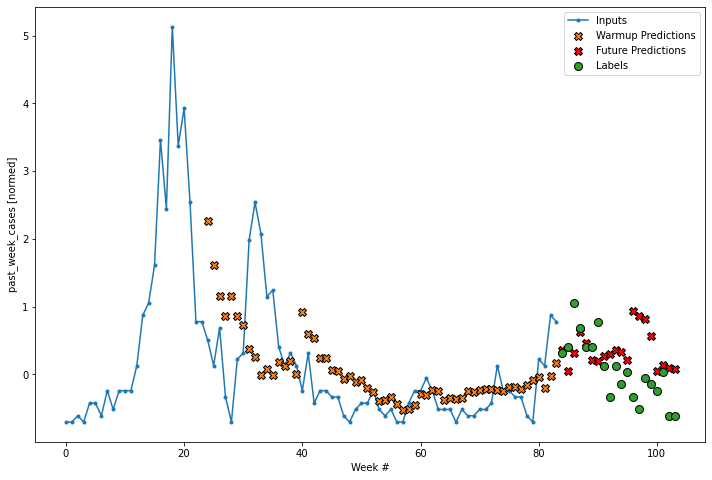

In [540]:
future_predictions_iq = lstm_ManyWeeks_window_iq.feedback_predict(iq_train_val, lstm_ManyWeeks_model_iq, n_future_weeks=20)

Predictions accuracy metrics for SJ:
* With full features at input:  
MAE = 0.336  
MSE = 0.271

* With 9 features:  
MAE = 0.366  
MSE = 0.381


Predictions accuracy metrics for Iq (only 20 in the future):
* With 9 features:  
MAE = 0.486
MSE = 0.382
    * This is too short a prediction period, and it happens to be quite without peaks in cases.

n_future_weeks :  140
n_past_weeks :  46
self.total_window_size :  24
Label width :  4
warmup inputs :  4
Warmup Predictions shape :  20
future inputs:  35
future window_tensor shape : 
 (35, 24, 9)
future predictions (140): 
 [0.6045585, 0.6781961, 0.6779846, 0.6958193, 0.6457048, 0.6029213, 0.58895105, 0.5122651, 1.0609114, 0.90034103, 0.96608156, 0.8461772, 0.81792605, 0.6649123, 0.68461144, 0.54821163, -0.0009597596, -0.1053334, -0.088190325, -0.2606522, -0.19930765, -0.32148778, -0.319429, -0.35465103, -0.36925086, -0.4147358, -0.44421953, -0.41748184, -0.47920612, -0.4769389, -0.5174345, -0.4730882, -0.51516527, -0.53986067, -0.57261795, -0.53839713, -0.569994, -0.6113982, -0.63873965, -0.60862076, -0.598897, -0.64663565, -0.6779188, -0.61515343, -0.5884944, -0.624652, -0.65008295, -0.5866008, -0.54015785, -0.52909887, -0.5695569, -0.48157287, -0.35643208, -0.3060046, -0.21178183, -0.1442956, -0.12609154, -0.14648746, -0.1216596, -0.09741459, -0.07179135, -0.13993716, -0.13401154

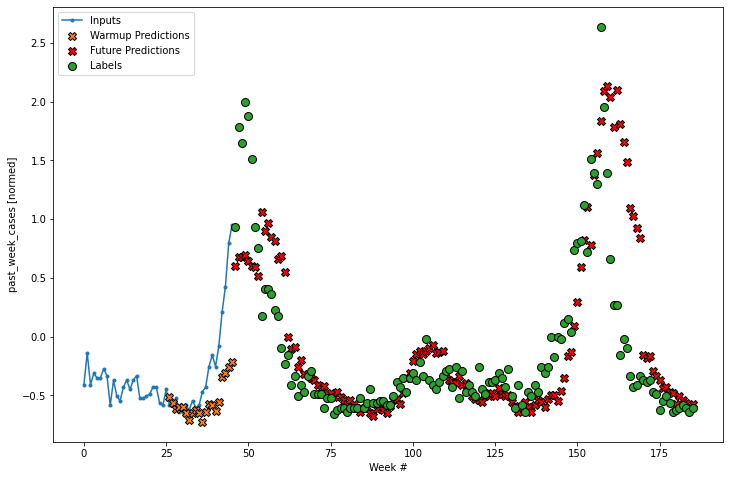

In [542]:
## or, trying to predict much further in the future:
far_future_predictions=lstm_ManyWeeks_window_sj.feedback_predict(sj_train_val, lstm_ManyWeeks_model_sj, n_future_weeks=140)

<a id='test_implementation'></a>

## Implement on test set

We confirm that the end of the training df is the beginning of the test df, for both cities. So we can use the last weeks from the training set as input for the test set.

In [543]:
sj_train_features.tail()

,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,weekofyear,total_cases
datetime,,,,,,,,,,,,,,,,,,,,,
2008-03-31,2008-03-25,0.07785,-0.039900,0.310471,0.296243,27.19,296.958571,296.957143,292.095714,299.7,...,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8,13,4
2008-04-07,2008-04-01,-0.03800,-0.016833,0.119371,0.066386,3.82,298.081429,298.228571,293.235714,299.8,...,3.82,14.662857,2.714286,26.242857,6.814286,30.6,22.2,0.5,14,3
2008-04-14,2008-04-08,-0.15520,-0.052750,0.137757,0.141214,16.96,297.460000,297.564286,292.732857,299.4,...,16.96,14.184286,2.185714,25.000000,5.714286,29.4,21.7,30.7,15,1
2008-04-21,2008-04-15,0.00180,0.001800,0.203900,0.209843,0.00,297.630000,297.778571,292.274286,299.7,...,0.00,13.858571,2.785714,25.314286,6.242857,29.4,21.7,11.2,16,3
2008-04-28,2008-04-22,-0.03700,-0.010367,0.077314,0.090586,0.00,298.672857,298.692857,294.280000,300.9,...,0.00,15.671429,3.957143,27.042857,7.514286,31.7,23.3,0.3,17,5


In [544]:
sj_test.head()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_sat_precip_amt_mm,reanalysis_relative_humidity_percent,reanalysis_tdtr_k,ndvi_ne,weekofyear,past_week_cases
datetime,,,,,,,,,
2008-05-05,-0.489472,-0.469860,-0.372968,1.654338,0.178035,1.127014,-0.320568,-0.565267,0
2008-05-12,-0.565099,-0.548773,-0.601494,-0.435303,0.016134,-0.033181,-0.313587,-0.498795,0
2008-05-19,-0.039958,-0.000666,0.464964,-0.716918,0.027878,3.834135,-0.185602,-0.432323,0
2008-05-26,-0.574446,-0.544485,1.074369,-0.832727,-1.514797,3.655643,-0.185602,-0.365851,0
2008-06-02,-0.359461,-0.330045,0.541140,-0.808679,-1.201061,1.989723,0.266610,-0.299379,0


In [279]:
iq_train_features.tail()    

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,...,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,weekofyear,past_week_cases,total_cases
datetime,,,,,,,,,,,,,,,,,,,,,
2010-05-27,0.966842,1.042060,0.081051,0.295969,-0.254003,1.250856,1.229952,0.940379,1.098309,0.982120,...,0.961152,0.242275,1.236626,0.926790,1.061273,0.948898,-0.547744,-0.368815,-0.149555,-0.240525
2010-06-03,-1.271985,-1.021196,-1.470219,-0.478828,0.631031,0.393222,0.195045,0.677290,0.594738,-0.581255,...,0.673614,-0.708735,-0.079296,0.008045,0.537810,0.393310,-0.395072,-0.301758,-0.242129,0.037335
2010-06-10,-0.206478,-1.207497,0.003864,-0.385454,-0.150650,-1.085371,-1.156232,0.005960,-0.664190,-0.280606,...,-0.060548,-0.697066,-3.405652,-2.299499,-1.331700,-1.590931,-0.859450,-0.234700,0.035591,-0.611004
2010-06-17,0.858505,0.090288,0.371741,0.678069,-0.129922,-1.301304,-1.209854,-0.119032,-0.412405,-0.581255,...,-0.193942,-0.545371,-2.272498,-1.124361,-2.079505,-0.162277,-0.722681,-0.167643,-0.612422,-0.611004
2010-06-24,0.420426,-0.076304,0.311503,0.565326,-0.029125,0.194369,0.527502,0.221673,0.300988,-0.340735,...,0.179561,0.738201,-0.033604,-0.376545,-0.209994,0.790159,-0.652706,-0.100586,-0.612422,-0.333145


In [280]:
iq_test.head()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_sat_precip_amt_mm,reanalysis_precip_amt_kg_per_m2,station_avg_temp_c,station_min_temp_c,ndvi_se,weekofyear
datetime,,,,,,,,,,
2010-07-01,17.654286,296.118571,307.9,293.7,82.29,34.11,27.440,21.5,0.225129,26
2010-07-08,16.320000,294.831429,307.7,292.2,25.30,9.10,27.025,21.2,0.330700,27
2010-07-15,18.030000,296.417143,306.4,292.5,62.14,61.09,26.950,21.6,0.212629,28
2010-07-22,15.394286,293.638571,306.4,289.3,47.80,19.60,26.900,14.2,0.122057,29
2010-07-29,15.468571,293.892857,308.1,290.5,56.30,18.93,27.050,16.9,0.250086,30


In [545]:
#sj_test = preprocess_data(data_path='data/Test_Data_Features.csv', city='sj')
#iq_test = preprocess_data(data_path='data/Test_Data_Features.csv', city='iq')

sj_test = pd.read_csv('data/Test_Data_Features.csv', index_col=[0, 1, 2]).loc['sj']
iq_test = pd.read_csv('data/Test_Data_Features.csv', index_col=[0, 1, 2]).loc['iq']

sj_test=process_df(sj_test)
iq_test=process_df(iq_test)

## that should have been done in process_df...
sj_test['past_week_cases']=0
iq_test['past_week_cases']=0

In [546]:
iq_test.head()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_sat_precip_amt_mm,reanalysis_relative_humidity_percent,reanalysis_tdtr_k,ndvi_ne,weekofyear,past_week_cases
datetime,,,,,,,,,
2010-07-01,0.342244,0.432692,0.429743,0.763824,0.447086,0.049955,-1.112735,-0.022348,0
2010-07-08,-0.695794,-0.601197,0.336761,-1.022740,-0.859533,0.389067,0.331633,0.044695,0
2010-07-15,0.634540,0.672518,-0.267621,0.132147,0.368306,0.109798,-0.781218,0.111738,0
2010-07-22,-1.415975,-1.559352,-0.267621,-0.317394,-0.095568,-0.694762,-2.378003,0.178781,0
2010-07-29,-1.358183,-1.355098,0.522724,-0.050930,-1.652262,1.140433,0.525015,0.245824,0


In [547]:
dfs=[sj_train, sj_test]
sj = pd.concat(dfs)
dfs=[iq_train, iq_test]
iq = pd.concat(dfs)

In [548]:
iq.describe()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_sat_precip_amt_mm,reanalysis_relative_humidity_percent,reanalysis_tdtr_k,ndvi_ne,weekofyear,past_week_cases
count,6.720000e+02,6.720000e+02,6.720000e+02,6.720000e+02,6.720000e+02,6.720000e+02,6.720000e+02,6.720000e+02,6.720000e+02
mean,9.485138e-15,-1.937058e-13,-8.273871e-14,-1.569883e-15,6.619457e-15,2.663214e-16,-5.129825e-16,2.615509e-17,-1.090398e-17
std,9.992546e-01,9.992546e-01,9.992546e-01,9.992546e-01,9.992546e-01,9.992546e-01,9.992546e-01,9.992546e-01,8.760772e-01
min,-3.447772e+00,-3.813363e+00,-2.972224e+00,-1.824179e+00,-4.068094e+00,-2.243186e+00,-2.478848e+00,-1.709960e+00,-7.026444e-01
25%,-6.870068e-01,-6.343738e-01,-7.900829e-01,-7.086651e-01,-5.503456e-01,-7.495756e-01,-7.810598e-01,-8.382159e-01,-5.174736e-01
50%,2.367050e-01,2.700569e-01,-5.592833e-02,-1.235338e-01,2.946318e-01,-8.082407e-02,-6.211048e-04,-2.234764e-02,-5.454645e-02
75%,7.474746e-01,7.420543e-01,6.786661e-01,5.905437e-01,7.783640e-01,7.323664e-01,6.909189e-01,8.492101e-01,0.000000e+00
max,2.327701e+00,2.086478e+00,3.312177e+00,4.162080e+00,1.314745e+00,2.786081e+00,2.997402e+00,1.720768e+00,1.003727e+01


Now, predict the sj test dataset.

n_future_weeks :  260
n_past_weeks :  930
self.total_window_size :  24
Label width :  4
warmup inputs :  225
Warmup Predictions shape :  904
future inputs:  65
future window_tensor shape : 
 (65, 24, 9)
future predictions (260): 
 [-0.5852315, -0.641219, -0.68668276, -0.63905346, -0.60225636, -0.65240836, -0.7170808, -0.6424977, -0.60364604, -0.65337855, -0.7157523, -0.62877303, -0.5142375, -0.55833006, -0.6327418, -0.52405506, -0.14567561, -0.013218779, 0.022365121, 0.20354953, 1.0515543, 1.4631995, 1.8623749, 2.3707364, 0.6640621, 0.75736076, 0.6859707, 0.71318305, 0.15267293, 0.23395726, 0.10641808, 0.12376465, 0.036744654, 0.20031464, 0.07207632, 0.04951186, -0.08710546, -0.12862214, -0.10265537, -0.16885138, -0.19493604, -0.2588086, -0.2678123, -0.2694615, -0.14372133, -0.19109671, -0.24390012, -0.24937928, -0.14074871, -0.25140923, -0.22877562, -0.29210895, -0.2667282, -0.3347905, -0.33419487, -0.32662156, -0.3842545, -0.41056454, -0.47855642, -0.41859892, -0.3235142, -0.34758997

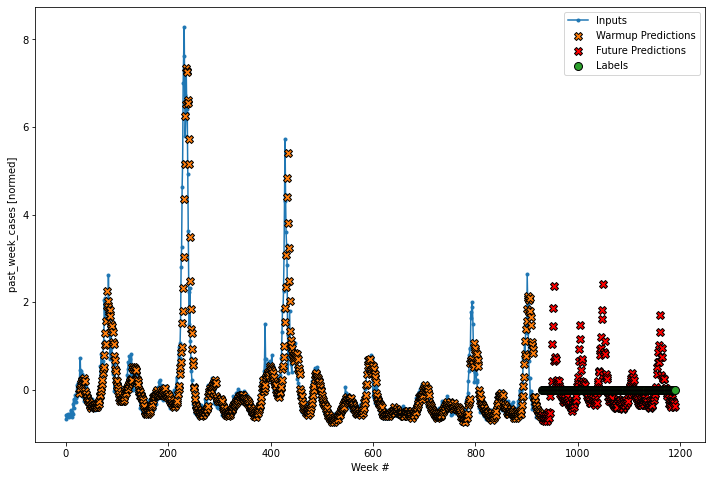

In [549]:
future_predictions_sj = lstm_ManyWeeks_window_sj.feedback_predict(sj, lstm_ManyWeeks_model_sj, n_future_weeks=len(sj_test))

n_future_weeks :  156
n_past_weeks :  516
self.total_window_size :  24
Label width :  4
warmup inputs :  122
Warmup Predictions shape :  492
future inputs:  39
future window_tensor shape : 
 (39, 24, 9)
future predictions (156): 
 [-0.24382186, -0.272203, -0.2968772, -0.33775404, -0.1871558, -0.27265415, -0.20458291, -0.2783244, 0.02479956, -0.073185086, -0.035540856, -0.043749362, -0.110397406, -0.1199135, -0.1835469, -0.16327111, -0.18246792, -0.15273093, -0.18066256, -0.12017899, -0.19369511, -0.13717897, -0.18809341, -0.008017312, -0.11783857, -0.10000454, -0.02493389, 0.12841842, 0.48553383, 0.46447703, 0.9304203, 1.3752792, 0.9920125, 0.80281794, 1.2015864, 1.6037511, 0.5337209, 0.28542006, 0.27742827, 0.3506761, -0.100765966, -0.12155229, -0.18063398, -0.07684852, -0.013945332, -0.027899694, -0.039590403, -0.029380176, 0.049053676, 0.017483307, 0.020587895, -0.056678087, 0.15072474, 0.12370108, 0.089781605, 0.009481803, 0.06685169, -0.11784214, -0.11992601, -0.08439446, -0.07252

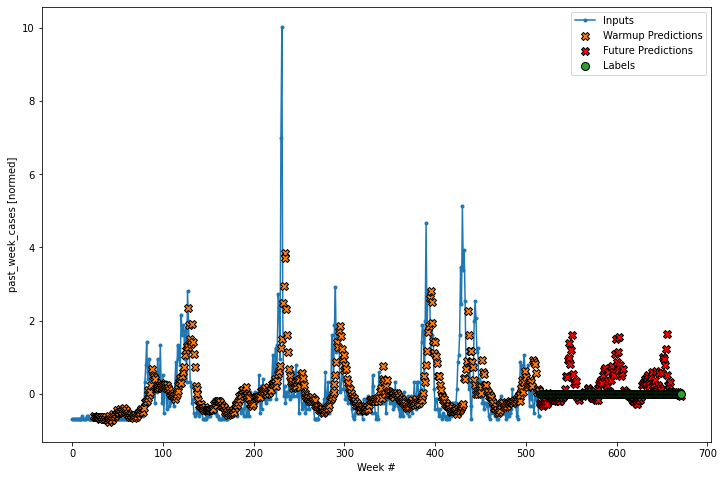

In [550]:
future_predictions_iq = lstm_ManyWeeks_window_iq.feedback_predict(iq, lstm_ManyWeeks_model_iq, n_future_weeks=len(iq_test))

### Output predictions to submissible form

In [552]:
submission = pd.read_csv("data/Submission_Format.csv",
                         index_col=[0, 1, 2])
submission

total_cases
city year weekofyear             
sj   2008 18                    0
          19                    0
          20                    0
          21                    0
          22                    0
...                           ...
iq   2013 22                    0
          23                    0
          24                    0
          25                    0
          26                    0

[416 rows x 1 columns]

In [553]:
for city in ['sj','iq']:
    print(city, len(submission.loc[city]))

sj 260
iq 156


Same length as the predictions we produced, great!

In [568]:
## de-normalize the data back to case count
mean,std=sj_train_features['total_cases'].mean(),sj_train_features['total_cases'].std()
sj_submit= [round(x*std+mean) for x in future_predictions_sj]
mean,std=iq_train_features['total_cases'].mean(),iq_train_features['total_cases'].std()
iq_submit= [round(x*std+mean) for x in future_predictions_iq]

<AxesSubplot:xlabel='year,weekofyear'>

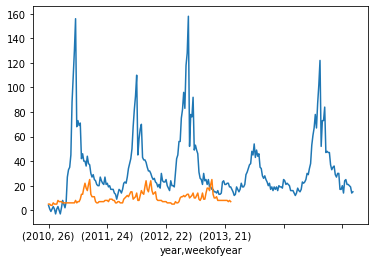

In [590]:
submission.total_cases.loc['sj'] = [int(x) for x in sj_submit]
submission.total_cases.loc['iq'] = [int(x) for x in iq_submit]
submission.total_cases.loc['sj'].plot()
submission.total_cases.loc['iq'].plot()

In [593]:
submission

total_cases
city year weekofyear             
sj   2008 18                    4
          19                    1
          20                    0
          21                    1
          22                    3
...                           ...
iq   2013 22                    8
          23                    8
          24                    7
          25                    8
          26                    7

[416 rows x 1 columns]

In [594]:
## Some predictions rounded to negative values, let's set them to 0
submission.total_cases.loc[submission.total_cases.values<0]=0

In [595]:
submission.to_csv("data/prediction.csv")

<a id='explicit_autoregressive_LSTM'></a>

## Explicitly trained auto-regressive LSTM

All the previous models up to this point are really trained to make one set of predictions, up to a few time steps in the future.  

Next we build a model that is explicitly trained to do the auto-regressive prediction.

In [737]:
class FeedBack_AutoRegress(tf.keras.Model):
    def __init__(self, units, out_steps, n_features=1):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(n_features)


In [738]:
autoregress_LSTM = FeedBack_AutoRegress(units=32, out_steps=30)

In [739]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack_AutoRegress.warmup = warmup

In [742]:
val_inputs.shape

TensorShape([175, 10, 21])

In [749]:
prediction, state = autoregress_LSTM.warmup(val_inputs)
print('Prediction shape : ', prediction.shape)
print('State shape : ', np.array(state).shape)

Prediction shape :  (175, 1)
State shape :  (2, 175, 32)


With the RNN's state, and an initial prediction you can now continue iterating the model feeding the predictions at each step back as the input.

The simplest approach for collecting the output predictions is to use a Python list and a tf.stack after the loop.


Note: Stacking a Python list like this only works with eager-execution, using Model.compile(..., run_eagerly=True) for training, or with a fixed length output. For a dynamic output length, you would need to use a tf.TensorArray instead of a Python list, and tf.range instead of the Python range.



In [743]:
def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)

    # Insert the first prediction.
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output.
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack_AutoRegress.call = call


## Thoughts on improving

May ideas exist on how we can make the prediction more sophisticated (if the task was more important and not just something I do for fun in my free time).

* Address small training sample  
The training data set is very small, for each city. That must be a limiting factor in the accuracy of the trained model predictions. Ideas to improve here include:
    * Common training sample between the two cities, adding the city as extra feature. That would ~double the training set, allowing deeper learning of connections between predictive features and labels, the part of it that is common between the two cities. Then we could still transfer the learned parameters onto two separate models, that would receive a final training focus on the data of each city.
    * Semi-supervised learning, where the models learn from the labeled and unlabeled samples together.